# Projet 4 : Notebook entrainement des modèles

### Sommaire

* [1-Mise en place de l'environnement de travail](#chapter1)
    * [1.1-Libriaires et fonctions](#section_1_1)
    * [1.2 Base de données](#section_1_2)
        * [1.2.1 Observation de la base de données de modélisation](#section_1_2_1)
        * [1.2.2 Séparation train/test du dataset](#section_1_2_2)
* [2-Modélisation Emission CO2](#chapter2)
    * [2.1 Cas sans EnergyStarScore](#section_2_1)
        * [2.1.1 Sélection des variables et des données](#section_2_1_1)
        * [2.1.2 Création du Pipeline de modification des données](#section_2_1_2)
        * [2.1.3 Entrainement des différents modèles avec Hyperparamètrage](#section_2_1_3)
    * [2.2 Cas avec EnergyStarScore](#section_2_2)
    * [2.3 Comparaison des deux modèles](#section_2_3)
* [3-Modélisation Emission CO2](#chapter3)
    * <font color='gray'> Structure similaire au chapitre 2

<font color='red'> Dans ce notebook parfois des objets ont le même nom et pourtant de réfère pas exqctement à la même chose. Parfois on dispose de Xtr qui sont les variables d'entrée d'entrainement et cela peut comprendre  l'energystarscore et parfois non. Compiler tout le notebook d'un coup amènera alors à des erreurs. Il est nécessaire de faire attention à ce que l'on compile pour savoir si les entrées correspondent bien.

### 1-Découverte et Nettoyage du dataset<a class="anchor" id="chapter1"></a>
Nous verrons dans cette partie la le chargement de la base de données:

    - L'importation des librairies et des fonctions utilisées dans la suite de l'étude
    - L'observation de la base de données
    - Le split pour l'entrainement et la validation
    
#### 1.1-Libriaires et fonctions <a class="anchor" id="section_1_1"></a>
##### Librairies :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import warnings
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

import plotly.express as px
import plotly.graph_objects as go

##### Fonctions :

In [14]:
def retour_score(X,y,Xtest,ytest,reg,lmetr=['explained_var','test_exp_var','error_max','test_error_max','r2','test_r2','RMSE','test_RMSE','MAE','test_MAE'],name=None):
    if name is None:
        name=str(type(reg)).split('.')[-1]
    lst_metrics=[metrics.explained_variance_score,metrics.max_error,metrics.r2_score,metrics.mean_squared_error,metrics.mean_absolute_error]
    res=[]
    ypred=reg.predict(X)
    ypred_test=reg.predict(Xtest)
    for k in lst_metrics:
        if k == metrics.mean_squared_error:
            res.append(np.sqrt(abs(k(y,ypred))))
            res.append(np.sqrt(abs(k(ytest,ypred_test))))
        else:
            res.append(k(y,ypred))
            res.append(k(ytest,ypred_test))
    return pd.DataFrame(np.array(res).reshape(1,10),columns=lmetr,index=[name])


def spider_plot(df_,name='',show=True):
    categories = df_.T.index[0::2]
    categories = [*categories, categories[0]]

    dtest=list(df_.T.iloc[1::2].values.reshape(1,-1)[0])
    dtrain=list(df_.T.iloc[0::2].values.reshape(1,-1)[0])
    dtest = [*dtest, dtest[0]]
    dtrain = [*dtrain, dtrain[0]]

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    plt.figure(figsize=(6,6))

    plt.subplot(polar=True)
    plt.plot(label_loc, dtest, label='Test')
    plt.plot(label_loc, dtrain, label='Train')
    plt.title(name, size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    if show:
        plt.show()
def pie_types_variable(d,name=''):
    """
    Renvoie en sortie un pie plot des distributions des types de variable dans le DataFrame donné en entrée.
    """
    (d.dtypes.value_counts()).plot.pie(autopct='%1.1f%%',startangle=0)
    plt.title('Pieplot des types de variables dans la bdd',name)
    plt.ylabel('')
    plt.show()
    
def desc_df(df,name=''):
    """
    Renvoie en sortie une description du df en entrée
    """
    val_manq=df.notna().mean().mean()
    dupli=df.duplicated().sum()
    nbligne=len(df.index)
    nbcolonne=len(df.columns)
    print("Dans la base de données",name ,"on a {} lignes avec {} variables. Elle est remplie à {} % et il y a {} lignes dupliquées".format(nbligne,nbcolonne,str(val_manq*100)[:5],dupli))
    
def pie_remplissage(d,name=''):
    """
    Renvoie en sortie un pie plot du pourcentage de remplissage du df
    """
    notna=d.notna().mean().mean()*100
    na=100-notna
    labels = 'valeurs manquantes','valeurs présentes'
    sizes = [na, notna]
    explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    plt.figure(facecolor=None)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=0)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('Pie Plot Valeurs présentes/manquantes '+name)
    plt.show()
    
def piebar_categorie(ser,angle=180,lab=1):
    """
    Renvoie en sortie un pie plot et un barplot de la variable qualitative de catégorie en entrée
    """
    labels = ser.value_counts().index.values
    sizes = ser.value_counts().values


    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.figure(facecolor=None)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=angle,labeldistance=1,rotatelabels=True)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
   

    #ax1.legend(loc='lower left')
    x_pos=np.arange(len(labels))
    ax2.bar(labels,sizes)
    fig.suptitle('Affichage catégorie: pie et bar plot',fontsize=15)
    ax2.set_xlabel('categories')
    ax2.grid()
    ax2.set_xticklabels(labels=labels,rotation=90)

    plt.show()

def comparaison_columns(d1,d2):
    dif1_2=list(set(d1.columns)-set(d2.columns)) 
    dif2_1=list(set(d2.columns)-set(d1.columns))
    commun=list(set(d1.columns)-set(dif1_2))
    exte=dif1_2+dif2_1
    return dif1_2,dif2_1,commun,exte

def transform(di,ret_latitude=True):
    lat=float(di.split("'latitude': ")[1][1:].split("'")[0])
    lon=float(di.split("'latitude': ")[1][1:].split("'")[4])
    if ret_latitude:
        return lat
    else : return lon



#### 1.2-Base de données <a class="anchor" id="section_1_2"></a>
##### 1.2.1 Observation de la base de données de modélisation <a class="anchor" id="section_1_2_1"></a>


In [2]:
df=pd.read_csv('test.csv')

In [5]:
df.LargestPropertyUseType.value_counts()

bureau            1022
commerce           889
Enseignement       312
entertainment      292
Logement-hotel     202
Autre              194
servicepublic      171
Name: LargestPropertyUseType, dtype: int64

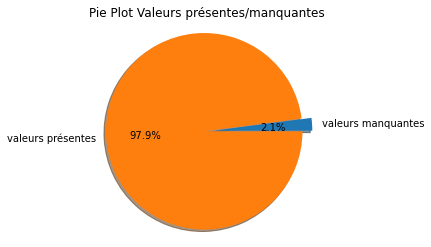

<Figure size 432x288 with 0 Axes>

In [8]:
pie_remplissage(df)

In [9]:
desc_df(df)

Dans la base de données  on a 3082 lignes avec 16 variables. Elle est remplie à 97.92 % et il y a 0 lignes dupliquées


Text(0.5, 1.0, 'Pourcentage de valeurs manquantes')

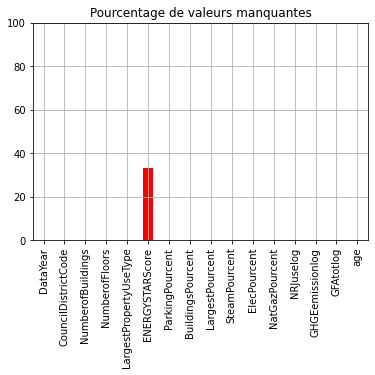

In [17]:
ax=(df.isna().mean()*100).plot(kind='bar',color='red')
plt.grid()
ax.set_ylim([0,100])
ax.set_title('Pourcentage de valeurs manquantes')

##### 1.2.2Séparation train/test du dataset <a class="anchor" id="section_1_2_2"></a>
 On split et on voit si le split correspond

In [3]:
Train,Test=train_test_split(df,stratify=df[['DataYear','CouncilDistrictCode','LargestPropertyUseType']])

In [4]:
Train.columns

Index(['DataYear', 'CouncilDistrictCode', 'NumberofBuildings',
       'NumberofFloors', 'LargestPropertyUseType', 'ENERGYSTARScore',
       'ParkingPourcent', 'BuildingsPourcent', 'LargestPourcent',
       'SteamPourcent', 'ElecPourcent', 'NatGazPourcent', 'NRJuselog',
       'GHGEemissionlog', 'GFAtotlog', 'age'],
      dtype='object')

In [5]:
Train.isna().mean()

DataYear                  0.000000
CouncilDistrictCode       0.000000
NumberofBuildings         0.000000
NumberofFloors            0.000000
LargestPropertyUseType    0.000000
ENERGYSTARScore           0.331026
ParkingPourcent           0.000000
BuildingsPourcent         0.000000
LargestPourcent           0.000000
SteamPourcent             0.000000
ElecPourcent              0.000000
NatGazPourcent            0.000000
NRJuselog                 0.000000
GHGEemissionlog           0.000000
GFAtotlog                 0.000000
age                       0.000000
dtype: float64

In [6]:
Train.shape,Test.shape

((2311, 16), (771, 16))

### 2-Modélisation Emission CO2<a class="anchor" id="chapter2"></a>


#### 2.1-Cas sans EnergyStarScore <a class="anchor" id="section_2_1"></a>
##### 2.1.1 Sélection des variables et des données <a class="anchor" id="section_2_1_1"></a>


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\miche\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


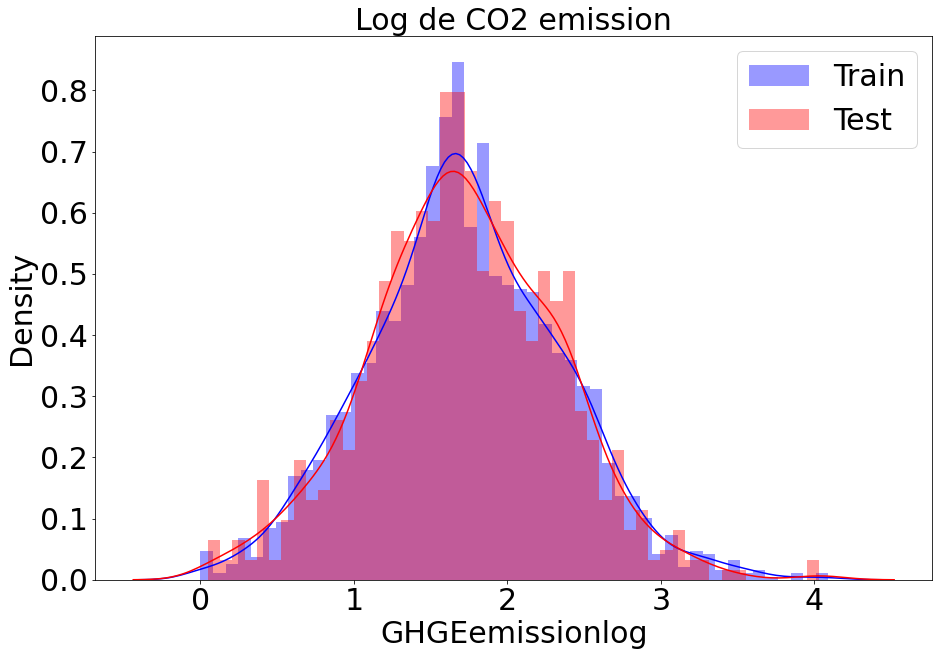

In [26]:
mpl.rcParams['font.size'] =30
f, axes = plt.subplots( figsize=(15, 10))
sns.distplot(Train['GHGEemissionlog'], color="b",ax=axes,label='Train',bins=50);
sns.distplot(Test['GHGEemissionlog'], color="r",ax=axes,label='Test',bins=50);
plt.title('Log de CO2 emission',fontsize=30)
plt.legend(fontsize=30)


In [876]:
df_res_sans_rien=pd.DataFrame(columns=['explained_var','test_exp_var','error_max','test_error_max','r2','test_r2','RMSE','test_RMSE','MAE','test_MAE'])

In [187]:
X=Train.dropna()[['DataYear','CouncilDistrictCode','NumberofBuildings','LargestPropertyUseType','NumberofFloors','ParkingPourcent','BuildingsPourcent','LargestPourcent','age','GFAtotlog']]
ytr=pd.DataFrame(Train.dropna().GHGEemissionlog).values      

In [649]:
X.shape

(1537, 10)

In [650]:
ytr.shape

(1537, 1)

##### 2.1.2 Création du Pipeline de modification des données <a class="anchor" id="section_2_1_2"></a>


In [188]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
num_attribs = list(X.drop(['DataYear','CouncilDistrictCode','LargestPropertyUseType'],axis=1))
cat_attribs = ['DataYear','CouncilDistrictCode','LargestPropertyUseType']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])


In [652]:
set_config(display="diagram")
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['NumberofBuildings', 'NumberofFloors',
                                  'ParkingPourcent', 'BuildingsPourcent',
                                  'LargestPourcent', 'age', 'GFAtotlog']),
                                ('cat', OneHotEncoder(),
                                 ['DataYear', 'CouncilDistrictCode',
                                  'LargestPropertyUseType'])])

In [189]:
Xtr = full_pipeline.fit_transform(X)

In [164]:
ytst=pd.DataFrame(Test.dropna().GHGEemissionlog).values      
Xtst=full_pipeline.transform(Test.dropna()[['DataYear','CouncilDistrictCode','NumberofBuildings','LargestPropertyUseType','NumberofFloors','ParkingPourcent','BuildingsPourcent','LargestPourcent','age','GFAtotlog']])

In [14]:
ytst.shape

(521, 1)

##### 2.1.3 Entrainement des différents modèles avec Hyperparamètrage <a class="anchor" id="section_2_1_3"></a>

##### LinearRegression

In [655]:
lin_reg = LinearRegression()
lin_reg.fit(Xtr, ytr)

LinearRegression()

In [656]:
retour_score(Xtr,ytr,Xtst,ytst,lin_reg,name='regression lineaire')

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,MSE,test_MSE,MAE,test_MAE
regression lineaire,0.513628,0.449285,1.599177,1.704873,0.513628,0.442522,0.427797,0.435042,0.331107,0.336443


In [657]:
df_res_sans_rien=df_res_sans_rien.append(retour_score(Xtr,ytr,Xtst,ytst,lin_reg,name='regression lineaire'))

##### ElasticNet pour savoir lasso, Ridge et linearReg

In [659]:
parametersGrid = {"alpha": [0, 0.0001,0.001, 0.01, 0.1, 1, 10, 100],
                  "max_iter": [ 9,8, 7],
                      "l1_ratio": np.arange(0.0, 1.1, 0.1),
                 }

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error',refit=True)
grid.fit(Xtr,ytr)
Y_pred = grid.predict(Xtst)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:593: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.76126737204369, tolerance: 0.04674158304689418

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:593: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent

In [660]:
grid.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=7)

In [661]:
df_res_sans_rien=df_res_sans_rien.append(retour_score(Xtr,ytr,Xtst,ytst,grid,name='elasticnet'))

In [662]:
df_res_sans_rien

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,MSE,test_MSE,MAE,test_MAE
regression lineaire,0.513628,0.449285,1.599177,1.704873,0.513628,0.442522,0.427797,0.435042,0.331107,0.336443
elasticnet,0.512904,0.452586,1.611027,1.688972,0.512904,0.445931,0.428116,0.433709,0.332420,0.335928


##### Svr avec RBF en noyau

In [229]:
svr = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-4, 2, 5)},refit=True,
     scoring='neg_mean_squared_error'
)
svr.fit(Xtr,ytr)



C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1.0, 10.0, 100.0, 1000.0],
                         'gamma': array([1.00000000e-04, 1.77827941e-03, 3.16227766e-02, 5.62341325e-01,
       1.00000000e+01])},
             scoring='neg_mean_squared_error')

In [663]:
svr_ss=svr.best_estimator_
svr_ss.fit(Xtr,ytr)


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVR(C=100.0, gamma=0.0031622776601683794)

In [668]:
svr_ss.get_params()

{'C': 100.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 0.0031622776601683794,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [669]:
df_res_sans_rien=df_res_sans_rien.append(retour_score(Xtr,ytr,Xtst,ytst,svr_ss,name='SVR_c100_eps0.1_gamma_0.003'))

In [670]:
df_res_sans_rien

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,MSE,test_MSE,MAE,test_MAE
regression lineaire,0.513628,0.449285,1.599177,1.704873,0.513628,0.442522,0.427797,0.435042,0.331107,0.336443
elasticnet,0.512904,0.452586,1.611027,1.688972,0.512904,0.445931,0.428116,0.433709,0.332420,0.335928
SVR_c100_eps0.1_gamma_0.003,0.562423,0.466297,1.675252,1.792508,0.562097,0.459939,0.405922,0.428192,0.298871,0.320007


##### KNNregressor 

In [671]:
knnreg = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={"n_neighbors":list(range(2,50))}, refit=True,
     scoring='neg_mean_squared_error'
)
knnreg.fit(Xtr,ytr)
print(knnreg.best_estimator_)


KNeighborsRegressor(n_neighbors=12)


In [672]:
str(knnreg.best_estimator_)

'KNeighborsRegressor(n_neighbors=12)'

In [673]:
df_res_sans_rien=df_res_sans_rien.append(retour_score(Xtr,ytr,Xtst,ytst,knnreg,name=str(knnreg.best_estimator_)))

In [674]:
df_res_sans_rien

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,MSE,test_MSE,MAE,test_MAE
regression lineaire,0.513628,0.449285,1.599177,1.704873,0.513628,0.442522,0.427797,0.435042,0.331107,0.336443
elasticnet,0.512904,0.452586,1.611027,1.688972,0.512904,0.445931,0.428116,0.433709,0.332420,0.335928
SVR_c100_eps0.1_gamma_0.003,0.562423,0.466297,1.675252,1.792508,0.562097,0.459939,0.405922,0.428192,0.298871,0.320007
KNeighborsRegressor(n_neighbors=12),0.551025,0.454622,1.891650,1.884343,0.547939,0.454194,0.412432,0.430463,0.318356,0.328408


##### Gradientboosting regressor

In [328]:
parameters = {'learning_rate': [0.001,0.01,0.1,0.3,0.5,0.9],
                  'subsample'    : [0.2,0.85,1],
                  'n_estimators' : [100,500,1700,1600,2000,2500],
                  'max_depth'    : [1,4,8,10,14],
              
                 }


GBR=GradientBoostingRegressor()
test_grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, n_jobs=-1)
test_grid_GBR.fit(Xtr, ytr)


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:925: RuntimeWarning:

overflow encountered in square

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning:

overflow encountered in reduce

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.9],
                         'max_depth': [1, 4, 8, 10, 14],
                         'n_estimators': [100, 500, 1700, 1600, 2000, 2500],
                         'subsample': [0.2, 0.85, 1]})

In [162]:
best=GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,
                          subsample=0.85)
best.fit(Xtr,ytr)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,
                          subsample=0.85)

Text(0.5, 1.0, 'Importance des variables en % sans EnergyStarScore pour CO2')

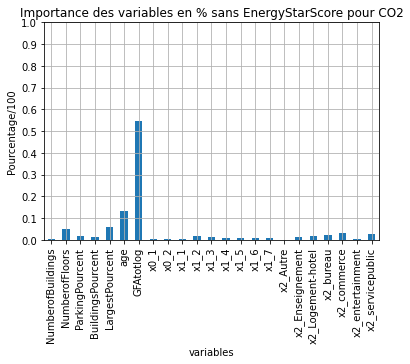

In [163]:
df_featureimp=pd.DataFrame(best.feature_importances_.reshape(1,-1),columns=full_pipeline.transformers_[0][-1]+list(full_pipeline.named_transformers_['cat'].get_feature_names()))
df_featureimp.T.plot(kind='bar',legend=False)
plt.grid()
plt.yticks(np.arange(0,1.1,0.1))
plt.ylabel('Pourcentage/100')
plt.xlabel('variables')

plt.title('Importance des variables en % sans EnergyStarScore pour CO2')

In [676]:
df_res_sans_rien

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,MSE,test_MSE,MAE,test_MAE
regression lineaire,0.513628,0.449285,1.599177,1.704873,0.513628,0.442522,0.427797,0.435042,0.331107,0.336443
elasticnet,0.512904,0.452586,1.611027,1.688972,0.512904,0.445931,0.428116,0.433709,0.332420,0.335928
SVR_c100_eps0.1_gamma_0.003,0.562423,0.466297,1.675252,1.792508,0.562097,0.459939,0.405922,0.428192,0.298871,0.320007
KNeighborsRegressor(n_neighbors=12),0.551025,0.454622,1.891650,1.884343,0.547939,0.454194,0.412432,0.430463,0.318356,0.328408


In [677]:
err=[metrics.mean_squared_error(ytst,ypred) for ypred in best.staged_predict(Xtst)]
errt=[metrics.mean_squared_error(ytr,ypred) for ypred in best.staged_predict(Xtr)]

In [678]:
brdt_n_rdt=np.argmin(err)

In [679]:
err[brdt_n_rdt]

0.0644850116793771

Text(0.5, 0, 'Nombre estimateur')

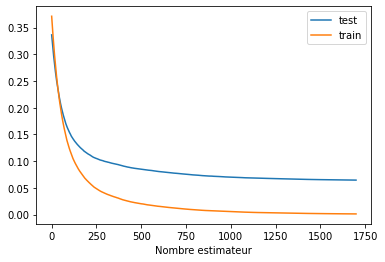

In [680]:
plt.plot(err,label='test')
plt.plot(errt,label='train')
plt.legend()
plt.xlabel('Nombre estimateur')

In [682]:
df_res_sans_rien=df_res_sans_rien.append(retour_score(Xtr,ytr,Xtst,ytst,best,name='GradientBoosting_lr_0.01_md_8'))

In [683]:
df_res_sans_rien

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,MSE,test_MSE,MAE,test_MAE
regression lineaire,0.513628,0.449285,1.599177,1.704873,0.513628,0.442522,0.427797,0.435042,0.331107,0.336443
elasticnet,0.512904,0.452586,1.611027,1.688972,0.512904,0.445931,0.428116,0.433709,0.332420,0.335928
SVR_c100_eps0.1_gamma_0.003,0.562423,0.466297,1.675252,1.792508,0.562097,0.459939,0.405922,0.428192,0.298871,0.320007
KNeighborsRegressor(n_neighbors=12),0.551025,0.454622,1.891650,1.884343,0.547939,0.454194,0.412432,0.430463,0.318356,0.328408
GradientBoosting_lr_0.01_md_8,0.996763,0.813048,0.250373,1.798450,0.996763,0.810056,0.034902,0.253939,0.026185,0.159831


##### RandomForestRegressor

In [684]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_rf_ss = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 2,refit=True)

In [685]:
grid_rf_ss.fit(Xtr,ytr)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [686]:
df_res_sans_rien=df_res_sans_rien.append(retour_score(Xtr,ytr,Xtst,ytst,grid_rf_ss,name=str(grid_rf_ss.best_estimator_)))

In [687]:
df_res_sans_rien

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,MSE,test_MSE,MAE,test_MAE
regression lineaire,0.513628,0.449285,1.599177,1.704873,0.513628,0.442522,0.427797,0.435042,0.331107,0.336443
elasticnet,0.512904,0.452586,1.611027,1.688972,0.512904,0.445931,0.428116,0.433709,0.332420,0.335928
SVR_c100_eps0.1_gamma_0.003,0.562423,0.466297,1.675252,1.792508,0.562097,0.459939,0.405922,0.428192,0.298871,0.320007
KNeighborsRegressor(n_neighbors=12),0.551025,0.454622,1.891650,1.884343,0.547939,0.454194,0.412432,0.430463,0.318356,0.328408
GradientBoosting_lr_0.01_md_8,0.996763,0.813048,0.250373,1.798450,0.996763,0.810056,0.034902,0.253939,0.026185,0.159831
"RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,\n min_samples_split=8, n_estimators=200)",0.684411,0.523499,1.539631,1.772445,0.684406,0.520841,0.344602,0.403326,0.267800,0.308056


##### MLPregressor

In [127]:
distributions = {'hidden_layer_sizes':[(100),(100,100),(100,100,100)]}
MLPreg = MLPRegressor(activation = 'relu', learning_rate='invscaling',verbose=True,early_stopping=True)


In [688]:
grid_MLP_ss = GridSearchCV(estimator = MLPreg, param_grid = distributions, n_jobs = -1, verbose = 2,refit=True)
grid_MLP_ss.fit(Xtr,ytr)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iteration 1, loss = 1.26308675
Validation score: -4.320096
Iteration 2, loss = 0.78554424
Validation score: -2.143409
Iteration 3, loss = 0.46049066
Validation score: -0.827513
Iteration 4, loss = 0.27174006
Validation score: -0.165364
Iteration 5, loss = 0.18189980
Validation score: 0.076512
Iteration 6, loss = 0.15351498
Validation score: 0.139085
Iteration 7, loss = 0.14349571
Validation score: 0.184284
Iteration 8, loss = 0.13495077
Validation score: 0.238500
Iteration 9, loss = 0.12643074
Validation score: 0.285345
Iteration 10, loss = 0.11936908
Validation score: 0.315736
Iteration 11, loss = 0.11500546
Validation score: 0.333739
Iteration 12, loss = 0.11140707
Validation score: 0.348344
Iteration 13, loss = 0.10838769
Validation score: 0.359186
Iteration 14, loss = 0.10586604
Validation score: 0.365433
Iteration 15, loss = 0.10368675
Validation score: 0.372846
Iteration 16, loss = 0.10195507
Validation score: 0.375117
Iteration 17, loss = 0.10034113
Validation score: 0.379482
It

GridSearchCV(estimator=MLPRegressor(early_stopping=True,
                                    learning_rate='invscaling', verbose=True),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [100, (100, 100),
                                                (100, 100, 100)]},
             verbose=2)

In [689]:
grid_MLP_ss.best_estimator_

MLPRegressor(early_stopping=True, hidden_layer_sizes=100,
             learning_rate='invscaling', verbose=True)

In [690]:
df_res_sans_rien=df_res_sans_rien.append(retour_score(Xtr,ytr,Xtst,ytst,grid_MLP_ss,name=str(grid_MLP_ss.best_estimator_)))

In [691]:
df_res_sans_rien

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,MSE,test_MSE,MAE,test_MAE
regression lineaire,0.513628,0.449285,1.599177,1.704873,0.513628,0.442522,0.427797,0.435042,0.331107,0.336443
elasticnet,0.512904,0.452586,1.611027,1.688972,0.512904,0.445931,0.428116,0.433709,0.332420,0.335928
SVR_c100_eps0.1_gamma_0.003,0.562423,0.466297,1.675252,1.792508,0.562097,0.459939,0.405922,0.428192,0.298871,0.320007
KNeighborsRegressor(n_neighbors=12),0.551025,0.454622,1.891650,1.884343,0.547939,0.454194,0.412432,0.430463,0.318356,0.328408
GradientBoosting_lr_0.01_md_8,0.996763,0.813048,0.250373,1.798450,0.996763,0.810056,0.034902,0.253939,0.026185,0.159831
"RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,\n min_samples_split=8, n_estimators=200)",0.684411,0.523499,1.539631,1.772445,0.684406,0.520841,0.344602,0.403326,0.267800,0.308056
"MLPRegressor(early_stopping=True, hidden_layer_sizes=100,\n learning_rate='invscaling', verbose=True)",0.624606,0.497696,1.568413,1.787832,0.624594,0.496329,0.375841,0.413514,0.287091,0.311151


#### Affichage du résultat et comparaison: 

In [716]:
df_res_sans_rien.rename(columns={"MSE":"RMSE","test_MSE":"test_RMSE"},inplace=True)


In [717]:
df_ss_r_exp=df_res_sans_rien.copy()

In [718]:
df_ss_r_exp.columns

Index(['explained_var', 'test_exp_var', 'error_max', 'test_error_max', 'r2',
       'test_r2', 'RMSE', 'test_RMSE', 'MAE', 'test_MAE'],
      dtype='object')

In [719]:
df_ss_r_exp[['explained_var','test_exp_var','r2','test_r2']]

,explained_var,test_exp_var,r2,test_r2
regression lineaire,0.513628,0.449285,0.513628,0.442522
elasticnet,0.512904,0.452586,0.512904,0.445931
SVR_c100_eps0.1_gamma_0.003,0.562423,0.466297,0.562097,0.459939
KNeighborsRegressor(n_neighbors=12),0.551025,0.454622,0.547939,0.454194
GradientBoosting_lr_0.01_md_8,0.996763,0.813048,0.996763,0.810056
"RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,\n min_samples_split=8, n_estimators=200)",0.684411,0.523499,0.684406,0.520841
"MLPRegressor(early_stopping=True, hidden_layer_sizes=100,\n learning_rate='invscaling', verbose=True)",0.624606,0.497696,0.624594,0.496329


In [720]:
df_ss_r_exp[['explained_var','test_exp_var','r2','test_r2']]=1/df_ss_r_exp[['explained_var','test_exp_var','r2','test_r2']]

In [721]:
df_ss_r_exp[['explained_var','error_max','r2','RMSE','MAE']]

,explained_var,error_max,r2,RMSE,MAE
regression lineaire,1.946933,1.599177,1.946933,0.427797,0.331107
elasticnet,1.949683,1.611027,1.949683,0.428116,0.332420
SVR_c100_eps0.1_gamma_0.003,1.778020,1.675252,1.779053,0.405922,0.298871
KNeighborsRegressor(n_neighbors=12),1.814799,1.891650,1.825019,0.412432,0.318356
GradientBoosting_lr_0.01_md_8,1.003248,0.250373,1.003248,0.034902,0.026185
"RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,\n min_samples_split=8, n_estimators=200)",1.461109,1.539631,1.461121,0.344602,0.267800
"MLPRegressor(early_stopping=True, hidden_layer_sizes=100,\n learning_rate='invscaling', verbose=True)",1.601009,1.568413,1.601040,0.375841,0.287091


In [722]:
scaler=MinMaxScaler(feature_range=(0.1,0.7))
df_ss_r_exp[['explained_var','error_max','r2','RMSE','MAE']]=scaler.fit_transform(df_ss_r_exp[['explained_var','error_max','r2','RMSE','MAE']])

In [723]:
df_ss_r_exp[['test_exp_var','test_error_max','test_r2','test_RMSE','test_MAE']]=scaler.transform(df_ss_r_exp[['test_exp_var','test_error_max','test_r2','test_RMSE','test_MAE']])

In [724]:
df_ss_r_exp

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.698257,0.875020,0.593081,0.631720,0.698257,0.896586,0.699514,0.710568,0.697428,0.707882
elasticnet,0.700000,0.864730,0.597413,0.625907,0.700000,0.885634,0.700000,0.708535,0.700000,0.706874
SVR_c100_eps0.1_gamma_0.003,0.591173,0.823541,0.620892,0.663757,0.591827,0.842335,0.666135,0.700116,0.634269,0.675678
KNeighborsRegressor(n_neighbors=12),0.614489,0.858456,0.700000,0.697329,0.620968,0.859768,0.676068,0.703582,0.672444,0.692138
GradientBoosting_lr_0.01_md_8,0.100000,0.243713,0.100000,0.665929,0.100000,0.246593,0.100000,0.434226,0.100000,0.361850
"RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,\n min_samples_split=8, n_estimators=200)",0.390265,0.674983,0.571313,0.656422,0.390272,0.681164,0.572568,0.662174,0.573390,0.652264
"MLPRegressor(early_stopping=True, hidden_layer_sizes=100,\n learning_rate='invscaling', verbose=True)",0.478955,0.737768,0.581835,0.662047,0.478975,0.741276,0.620235,0.677719,0.611188,0.658329


In [725]:
df_ss_r_exp.describe()

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.510448,0.725459,0.537790,0.657587,0.511471,0.736194,0.576360,0.656703,0.569817,0.636431
std,0.213091,0.225037,0.197718,0.023738,0.213671,0.229985,0.214986,0.099698,0.212278,0.123042
min,0.100000,0.243713,0.100000,0.625907,0.100000,0.246593,0.100000,0.434226,0.100000,0.361850
25%,0.434610,0.706376,0.576574,0.644071,0.434624,0.711220,0.596402,0.669947,0.592289,0.655296
50%,0.591173,0.823541,0.593081,0.662047,0.591827,0.842335,0.666135,0.700116,0.634269,0.675678
75%,0.656373,0.861593,0.609152,0.664843,0.659612,0.872701,0.687791,0.706058,0.684936,0.699506
max,0.700000,0.875020,0.700000,0.697329,0.700000,0.896586,0.700000,0.710568,0.700000,0.707882


In [726]:
len(df_ss_r_exp.index)

7

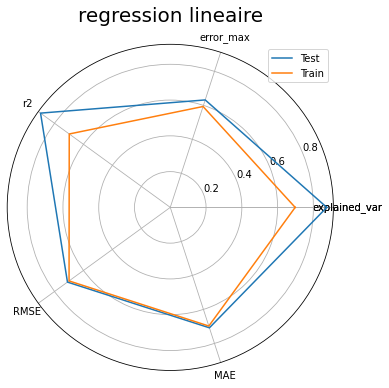

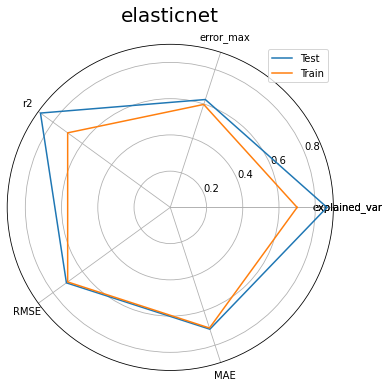

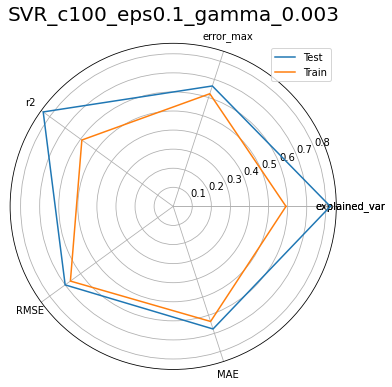

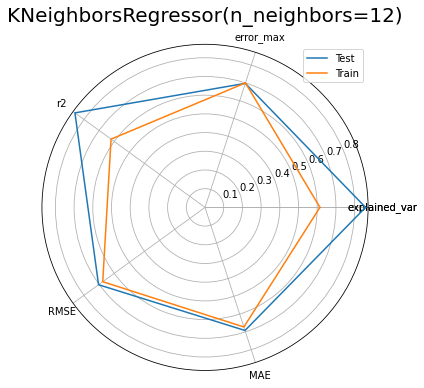

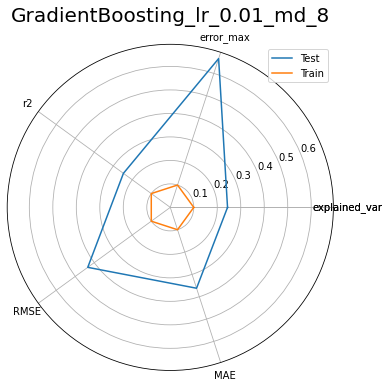

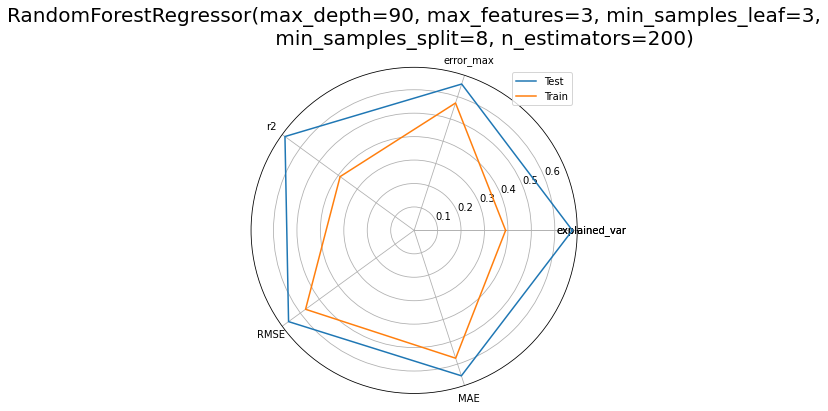

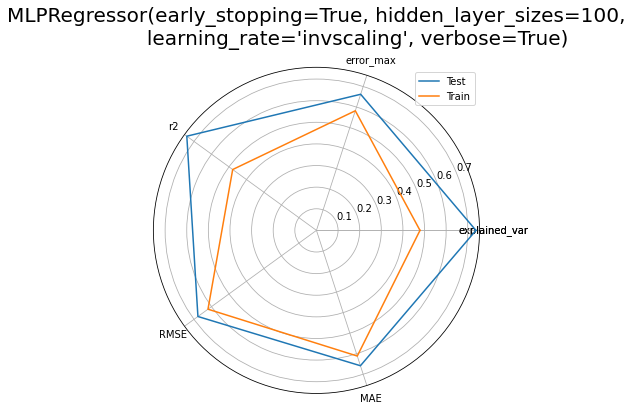

In [727]:


for col in df_ss_r_exp.index:
    spider_plot(df_ss_r_exp.loc[col],name=col,show=False)
 


#### 2.2-Cas avec EnergyStarScore <a class="anchor" id="section_2_2"></a>
#### Sélection des données

In [750]:
df_res_nrjstar=pd.DataFrame(columns=['explained_var','test_exp_var','error_max','test_error_max','r2','test_r2','RMSE','test_RMSE','MAE','test_MAE'])

In [192]:
X=Train.dropna()[['ENERGYSTARScore','DataYear','CouncilDistrictCode','NumberofBuildings','LargestPropertyUseType','NumberofFloors','ParkingPourcent','BuildingsPourcent','LargestPourcent','age','GFAtotlog']]
ytr=pd.DataFrame(Train.dropna().GHGEemissionlog).values  

In [193]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
num_attribs = list(X.drop(['DataYear','CouncilDistrictCode','LargestPropertyUseType'],axis=1))
cat_attribs = ['DataYear','CouncilDistrictCode','LargestPropertyUseType']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])



In [194]:
X=full_pipeline.fit_transform(X)

In [195]:
ytst_nrj=pd.DataFrame(Test.dropna().GHGEemissionlog).values      
Xtst_nrj=full_pipeline.transform(Test.dropna()[['ENERGYSTARScore','DataYear','CouncilDistrictCode','NumberofBuildings','LargestPropertyUseType','NumberofFloors','ParkingPourcent','BuildingsPourcent','LargestPourcent','age','GFAtotlog']])

In [196]:
Xtst_nrj.shape,Xtst.shape

((512, 24), (512, 23))

#### différents modèles: 
##### Elasticnet

In [743]:
parametersGrid = {"alpha": [0, 0.0001,0.001, 0.01, 0.1, 1, 10, 100],
                  "max_iter": [ 9,8, 7],
                      "l1_ratio": np.arange(0.0, 1.1, 0.1),
                 }

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error',refit=True)
grid.fit(X,ytr)


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:593: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.6059281508044, tolerance: 0.04674158304689418

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:593: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_iter': [9, 8, 7]},
             scoring='neg_mean_squared_error')

In [744]:
grid.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=9)

In [751]:
df_res_nrjstar=df_res_nrjstar.append(retour_score(X,ytr,Xtst_nrj,ytst_nrj,grid,name=str(grid.best_estimator_)))

In [752]:
df_res_nrjstar

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=9)",0.583872,0.535736,1.735535,1.590356,0.583872,0.526839,0.395701,0.400794,0.311058,0.318353


###### SVR

In [756]:
svr = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-4, 2, 5)},refit=True,
     scoring='neg_mean_squared_error'
)
svr.fit(X,ytr)



C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1.0, 10.0, 100.0, 1000.0],
                         'gamma': array([1.00000000e-04, 3.16227766e-03, 1.00000000e-01, 3.16227766e+00,
       1.00000000e+02])},
             scoring='neg_mean_squared_error')

In [757]:
svr.best_estimator_

SVR(C=100.0, gamma=0.0031622776601683794)

In [758]:
df_res_nrjstar=df_res_nrjstar.append(retour_score(X,ytr,Xtst_nrj,ytst_nrj,svr,name=str(svr.best_estimator_)))

In [760]:
df_res_nrjstar

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=9)",0.583872,0.535736,1.735535,1.590356,0.583872,0.526839,0.395701,0.400794,0.311058,0.318353
"SVR(C=100.0, gamma=0.0031622776601683794)",0.630793,0.565822,1.834279,1.668372,0.630771,0.559901,0.372736,0.386538,0.274324,0.289995


KNN

In [761]:
knnreg = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={"n_neighbors":list(range(2,50))}, refit=True,
     scoring='neg_mean_squared_error'
)
knnreg.fit(X,ytr)
print(knnreg.best_estimator_)

KNeighborsRegressor(n_neighbors=8)


In [762]:
df_res_nrjstar=df_res_nrjstar.append(retour_score(X,ytr,Xtst_nrj,ytst_nrj,knnreg,name=str(knnreg.best_estimator_)))

In [763]:
df_res_nrjstar

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=9)",0.583872,0.535736,1.735535,1.590356,0.583872,0.526839,0.395701,0.400794,0.311058,0.318353
"SVR(C=100.0, gamma=0.0031622776601683794)",0.630793,0.565822,1.834279,1.668372,0.630771,0.559901,0.372736,0.386538,0.274324,0.289995
KNeighborsRegressor(n_neighbors=8),0.625817,0.524545,1.691613,1.817288,0.622952,0.524142,0.376662,0.401935,0.290836,0.312026


In [454]:
parameters = {'learning_rate': [0.001,0.01,0.1,0.3,0.5,0.9],
                  'subsample'    : [0.2,0.85,1],
                  'n_estimators' : [100,500,1700,1600,2000,2500],
                  'max_depth'    : [1,4,8,10,14],
              
                 }


GBR=GradientBoostingRegressor()
test_grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, n_jobs=-1)
test_grid_GBR.fit(X, ytr)
print(test_grid_GBR.best_estimator_)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:925: RuntimeWarning:

overflow encountered in square

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,
                          subsample=0.85)


In [156]:
best_nrj=GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,
                          subsample=0.85)
best_nrj.fit(X, ytr)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,
                          subsample=0.85)

Text(0.5, 1.0, 'Importance des variables en % avec EnergyStarScore pour CO2')

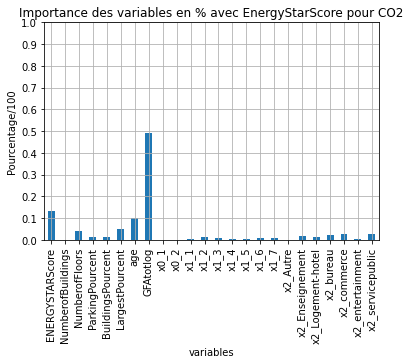

In [157]:
df_featureimp=pd.DataFrame(best_nrj.feature_importances_.reshape(1,-1),columns=full_pipeline.transformers_[0][-1]+list(full_pipeline.named_transformers_['cat'].get_feature_names()))
df_featureimp.T.plot(kind='bar',legend=False)
plt.grid()
plt.yticks(np.arange(0,1.1,0.1))
plt.ylabel('Pourcentage/100')
plt.xlabel('variables')

plt.title('Importance des variables en % avec EnergyStarScore pour CO2')

In [770]:
df_res_nrjstar=df_res_nrjstar.append(retour_score(X,ytr,Xtst_nrj,ytst_nrj,best_nrj,name='GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,subsample=0.85)'))

In [771]:
df_res_nrjstar

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=9)",0.583872,0.535736,1.735535,1.590356,0.583872,0.526839,0.395701,0.400794,0.311058,0.318353
"SVR(C=100.0, gamma=0.0031622776601683794)",0.630793,0.565822,1.834279,1.668372,0.630771,0.559901,0.372736,0.386538,0.274324,0.289995
KNeighborsRegressor(n_neighbors=8),0.625817,0.524545,1.691613,1.817288,0.622952,0.524142,0.376662,0.401935,0.290836,0.312026
"GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,subsample=0.85)",0.999028,0.814967,0.102980,1.187526,0.999028,0.811784,0.019124,0.252781,0.014620,0.165833


In [460]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestRegressor()
gridrfr = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 2,refit=True)

In [777]:
gridrfr.fit(X,ytr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [90, 110, 120],
                         'max_features': [3, 4], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [7, 8], 'n_estimators': [200]},
             verbose=2)

In [778]:
gridrfr.best_estimator_

RandomForestRegressor(max_depth=110, max_features=4, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=200)

In [463]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [ 90,110,120],
    'max_features': [ 3,4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [7,8],
    'n_estimators': [200]
}
rf = RandomForestRegressor()
gridrfr = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 2,refit=True)

In [464]:
gridrfr.fit(X,ytr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [90, 110, 120],
                         'max_features': [3, 4], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [7, 8], 'n_estimators': [200]},
             verbose=2)

In [780]:
gridrfr.best_estimator_

RandomForestRegressor(max_depth=110, max_features=4, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=200)

In [781]:
df_res_nrjstar=df_res_nrjstar.append(retour_score(X,ytr,Xtst_nrj,ytst_nrj,gridrfr,name=str(gridrfr.best_estimator_)))

In [782]:
df_res_nrjstar

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=9)",0.583872,0.535736,1.735535,1.590356,0.583872,0.526839,0.395701,0.400794,0.311058,0.318353
"SVR(C=100.0, gamma=0.0031622776601683794)",0.630793,0.565822,1.834279,1.668372,0.630771,0.559901,0.372736,0.386538,0.274324,0.289995
KNeighborsRegressor(n_neighbors=8),0.625817,0.524545,1.691613,1.817288,0.622952,0.524142,0.376662,0.401935,0.290836,0.312026
"GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,subsample=0.85)",0.999028,0.814967,0.102980,1.187526,0.999028,0.811784,0.019124,0.252781,0.014620,0.165833
"RandomForestRegressor(max_depth=110, max_features=4, min_samples_leaf=3,\n min_samples_split=8, n_estimators=200)",0.781811,0.642258,1.563976,1.291016,0.781804,0.639210,0.286535,0.349981,0.222984,0.274041


In [783]:
distributions = {'hidden_layer_sizes':[(100),(100,100),(100,100,100)]}
MLPreg = MLPRegressor(activation = 'relu', learning_rate='invscaling',verbose=True,early_stopping=True)
grid_MLP = GridSearchCV(estimator = MLPreg, param_grid = distributions, n_jobs = -1, verbose = 2,refit=True)
grid_MLP.fit(X,ytr)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iteration 1, loss = 1.16035833
Validation score: -1.342364
Iteration 2, loss = 0.32245486
Validation score: -0.795625
Iteration 3, loss = 0.25426923
Validation score: -0.893465
Iteration 4, loss = 0.19684436
Validation score: 0.108959
Iteration 5, loss = 0.13676774
Validation score: 0.336771
Iteration 6, loss = 0.12951860
Validation score: 0.417872
Iteration 7, loss = 0.11098409
Validation score: 0.430816
Iteration 8, loss = 0.10285603
Validation score: 0.435615
Iteration 9, loss = 0.09604590
Validation score: 0.483403
Iteration 10, loss = 0.09127683
Validation score: 0.505177
Iteration 11, loss = 0.08815997
Validation score: 0.518884
Iteration 12, loss = 0.08522237
Validation score: 0.520733
Iteration 13, loss = 0.08296323
Validation score: 0.532698
Iteration 14, loss = 0.08085954
Validation score: 0.547817
Iteration 15, loss = 0.07917389
Validation score: 0.553242
Iteration 16, loss = 0.07764125
Validation score: 0.556148
Iteration 17, loss = 0.07650777
Validation score: 0.557841
Ite

GridSearchCV(estimator=MLPRegressor(early_stopping=True,
                                    learning_rate='invscaling', verbose=True),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [100, (100, 100),
                                                (100, 100, 100)]},
             verbose=2)

In [784]:
df_res_nrjstar=df_res_nrjstar.append(retour_score(X,ytr,Xtst_nrj,ytst_nrj,grid_MLP,name=str(grid_MLP.best_estimator_)))

In [785]:
df_res_sans_rien

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.513628,0.449285,1.599177,1.704873,0.513628,0.442522,0.427797,0.435042,0.331107,0.336443
elasticnet,0.512904,0.452586,1.611027,1.688972,0.512904,0.445931,0.428116,0.433709,0.332420,0.335928
SVR_c100_eps0.1_gamma_0.003,0.562423,0.466297,1.675252,1.792508,0.562097,0.459939,0.405922,0.428192,0.298871,0.320007
KNeighborsRegressor(n_neighbors=12),0.551025,0.454622,1.891650,1.884343,0.547939,0.454194,0.412432,0.430463,0.318356,0.328408
GradientBoosting_lr_0.01_md_8,0.996763,0.813048,0.250373,1.798450,0.996763,0.810056,0.034902,0.253939,0.026185,0.159831
"RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,\n min_samples_split=8, n_estimators=200)",0.684411,0.523499,1.539631,1.772445,0.684406,0.520841,0.344602,0.403326,0.267800,0.308056
"MLPRegressor(early_stopping=True, hidden_layer_sizes=100,\n learning_rate='invscaling', verbose=True)",0.624606,0.497696,1.568413,1.787832,0.624594,0.496329,0.375841,0.413514,0.287091,0.311151


In [786]:
df_res_nrjstar

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=9)",0.583872,0.535736,1.735535,1.590356,0.583872,0.526839,0.395701,0.400794,0.311058,0.318353
"SVR(C=100.0, gamma=0.0031622776601683794)",0.630793,0.565822,1.834279,1.668372,0.630771,0.559901,0.372736,0.386538,0.274324,0.289995
KNeighborsRegressor(n_neighbors=8),0.625817,0.524545,1.691613,1.817288,0.622952,0.524142,0.376662,0.401935,0.290836,0.312026
"GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,subsample=0.85)",0.999028,0.814967,0.102980,1.187526,0.999028,0.811784,0.019124,0.252781,0.014620,0.165833
"RandomForestRegressor(max_depth=110, max_features=4, min_samples_leaf=3,\n min_samples_split=8, n_estimators=200)",0.781811,0.642258,1.563976,1.291016,0.781804,0.639210,0.286535,0.349981,0.222984,0.274041
"MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 100),\n learning_rate='invscaling', verbose=True)",0.697954,0.577511,1.582982,1.745702,0.697633,0.576017,0.337303,0.379394,0.258008,0.288980


In [787]:
df_ss_r_expnrj=df_res_nrjstar.copy()

In [788]:
df_ss_r_expnrj[['explained_var','test_exp_var','r2','test_r2']]=1/df_ss_r_expnrj[['explained_var','test_exp_var','r2','test_r2']]

In [789]:
df_ss_r_expnrj[['explained_var','error_max','r2','RMSE','MAE']]=scaler.transform(df_ss_r_expnrj[['explained_var','error_max','r2','RMSE','MAE']])

In [790]:
df_ss_r_expnrj.columns

Index(['explained_var', 'test_exp_var', 'error_max', 'test_error_max', 'r2',
       'test_r2', 'RMSE', 'test_RMSE', 'MAE', 'test_MAE'],
      dtype='object')

In [791]:
df_ss_r_expnrj[['test_exp_var','test_error_max','test_r2','test_RMSE','test_MAE']]=scaler.transform(df_ss_r_expnrj[['test_exp_var','test_error_max','test_r2','test_RMSE','test_MAE']])

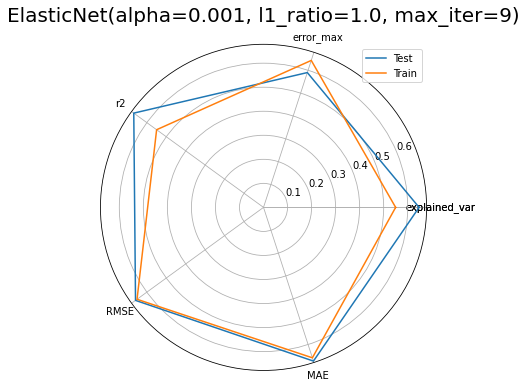

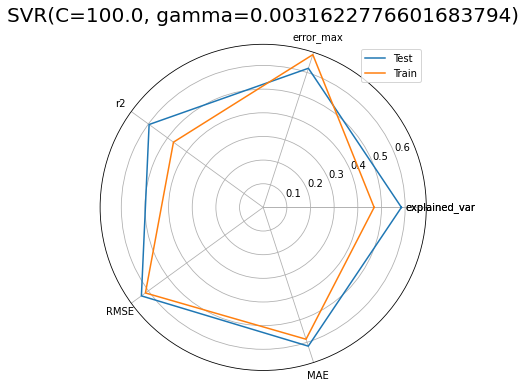

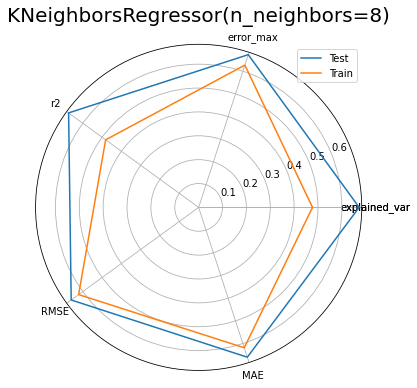

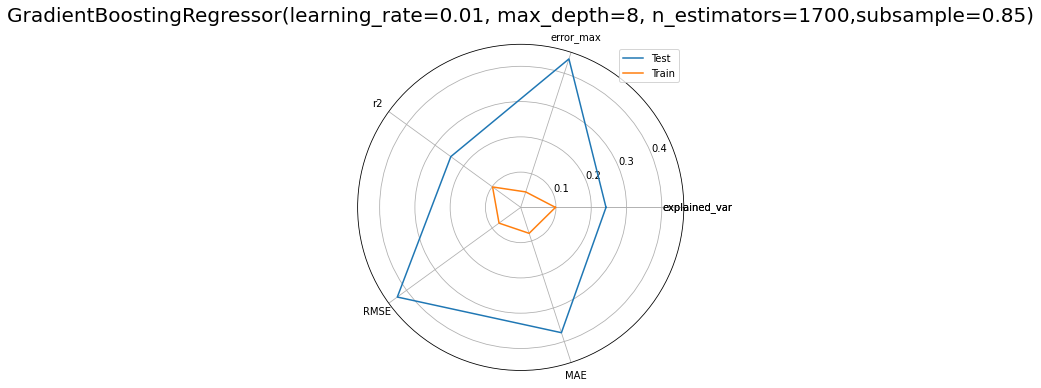

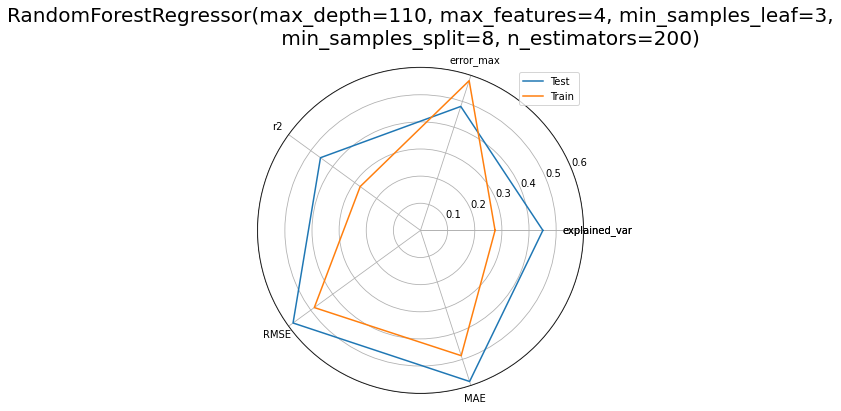

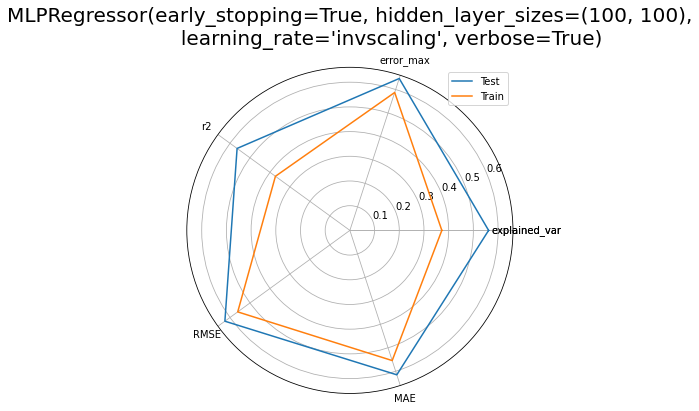

In [792]:

for col in df_ss_r_expnrj.index:
    spider_plot(df_ss_r_expnrj.loc[col],name=col,show=False)
 

#### 2.3-Comparaison des deux modèles <a class="anchor" id="section_2_3"></a>


In [793]:
cm = sns.light_palette("green", as_cmap=True) 

df_res_nrjstar.style.background_gradient(cmap=cm).set_precision(4).highlight_null('red').highlight_min(axis=0, color='red').highlight_max(axis=0, color='blue')


<ipython-input-793-2372a4d975b1>:3: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=9)",0.5839,0.5357,1.7355,1.5904,0.5839,0.5268,0.3957,0.4008,0.3111,0.3184
"SVR(C=100.0, gamma=0.0031622776601683794)",0.6308,0.5658,1.8343,1.6684,0.6308,0.5599,0.3727,0.3865,0.2743,0.2900
KNeighborsRegressor(n_neighbors=8),0.6258,0.5245,1.6916,1.8173,0.6230,0.5241,0.3767,0.4019,0.2908,0.3120
"GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,subsample=0.85)",0.9990,0.8150,0.1030,1.1875,0.9990,0.8118,0.0191,0.2528,0.0146,0.1658
"RandomForestRegressor(max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200)",0.7818,0.6423,1.5640,1.2910,0.7818,0.6392,0.2865,0.3500,0.2230,0.2740
"MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 100), learning_rate='invscaling', verbose=True)",0.6980,0.5775,1.5830,1.7457,0.6976,0.5760,0.3373,0.3794,0.2580,0.2890


In [794]:
df_res_sans_rien.style.background_gradient(cmap=cm).set_precision(4).highlight_null('red').highlight_min(axis=0, color='red').highlight_max(axis=0, color='blue')


<ipython-input-794-f96938ed6a77>:1: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.5136,0.4493,1.5992,1.7049,0.5136,0.4425,0.4278,0.4350,0.3311,0.3364
elasticnet,0.5129,0.4526,1.6110,1.6890,0.5129,0.4459,0.4281,0.4337,0.3324,0.3359
SVR_c100_eps0.1_gamma_0.003,0.5624,0.4663,1.6753,1.7925,0.5621,0.4599,0.4059,0.4282,0.2989,0.3200
KNeighborsRegressor(n_neighbors=12),0.5510,0.4546,1.8917,1.8843,0.5479,0.4542,0.4124,0.4305,0.3184,0.3284
GradientBoosting_lr_0.01_md_8,0.9968,0.8130,0.2504,1.7984,0.9968,0.8101,0.0349,0.2539,0.0262,0.1598
"RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200)",0.6844,0.5235,1.5396,1.7724,0.6844,0.5208,0.3446,0.4033,0.2678,0.3081
"MLPRegressor(early_stopping=True, hidden_layer_sizes=100, learning_rate='invscaling', verbose=True)",0.6246,0.4977,1.5684,1.7878,0.6246,0.4963,0.3758,0.4135,0.2871,0.3112


In [200]:
df_res_tot=pd.DataFrame(retour_score(Xtr,ytr,Xtst,ytst,best,name='GBR sans nrjstar'))

In [201]:
df_res_tot=df_res_tot.append(retour_score(X,ytr,Xtst_nrj,ytst_nrj,best_nrj,name='GBR avec nrjstar'))

In [202]:
df_res_tot

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
GBR sans nrjstar,0.996653,0.792340,0.193067,2.545814,0.996653,0.790897,0.034389,0.292268,0.025928,0.177423
GBR avec nrjstar,0.998916,0.817919,0.086073,2.440350,0.998916,0.817426,0.019570,0.273099,0.014794,0.172326


In [822]:
df_res_nrjstar

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=9)",0.583872,0.535736,1.735535,1.590356,0.583872,0.526839,0.395701,0.400794,0.311058,0.318353
"SVR(C=100.0, gamma=0.0031622776601683794)",0.630793,0.565822,1.834279,1.668372,0.630771,0.559901,0.372736,0.386538,0.274324,0.289995
KNeighborsRegressor(n_neighbors=8),0.625817,0.524545,1.691613,1.817288,0.622952,0.524142,0.376662,0.401935,0.290836,0.312026
"GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1700,subsample=0.85)",0.999028,0.814967,0.102980,1.187526,0.999028,0.811784,0.019124,0.252781,0.014620,0.165833
"RandomForestRegressor(max_depth=110, max_features=4, min_samples_leaf=3,\n min_samples_split=8, n_estimators=200)",0.781811,0.642258,1.563976,1.291016,0.781804,0.639210,0.286535,0.349981,0.222984,0.274041
"MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 100),\n learning_rate='invscaling', verbose=True)",0.697954,0.577511,1.582982,1.745702,0.697633,0.576017,0.337303,0.379394,0.258008,0.288980


In [170]:
ypred_=best.predict(Xtst)

In [176]:
ypred_nrj=best_nrj.predict(Xtst_nrj)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


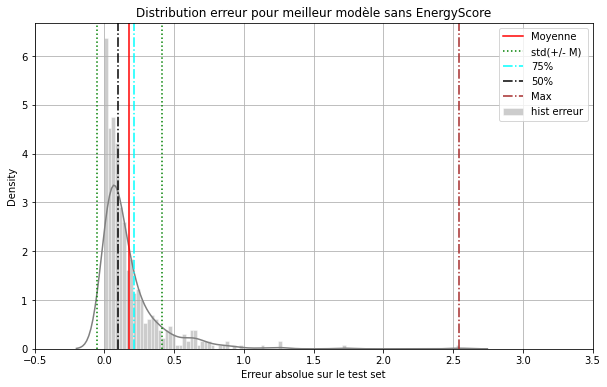

In [185]:
err=pd.DataFrame(np.abs(ypred_.reshape(-1,1)-ytst))
plt.figure(figsize=(10,6))
sns.distplot(err,bins=100,label='hist erreur',hist_kws={'edgecolor':"white",'color':'gray'},kde_kws={'color':'gray'})
plt.axvline(err.mean().values,color='red',label='Moyenne',linestyle='-')
plt.axvline(err.mean().values-err.describe().loc['std'].values,color='green',label='std(+/- M)',linestyle=':')
plt.axvline(err.mean().values+err.describe().loc['std'].values,color='green',linestyle=':')
plt.axvline(err.describe().loc['75%'].values,color='cyan',label='75%',linestyle='-.')
plt.axvline(err.describe().loc['50%'].values,color='black',label='50%',linestyle='-.')
plt.axvline(err.max().values,color='brown',label='Max',linestyle='-.')
plt.xticks(np.arange(-0.5, 4, 0.5))
plt.xlabel('Erreur absolue sur le test set')
plt.title('Distribution erreur pour meilleur modèle sans EnergyScore')
plt.legend(loc='upper right')
plt.grid()

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


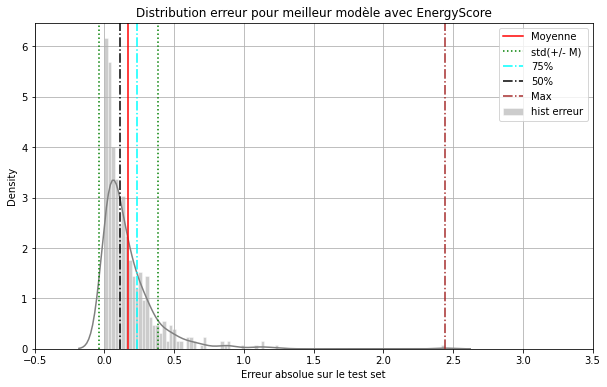

In [186]:
err=pd.DataFrame(np.abs(ypred_nrj.reshape(-1,1)-ytst))
plt.figure(figsize=(10,6))
sns.distplot(err,bins=100,label='hist erreur',hist_kws={'edgecolor':"white",'color':'gray'},kde_kws={'color':'gray'})
plt.axvline(err.mean().values,color='red',label='Moyenne',linestyle='-')
plt.axvline(err.mean().values-err.describe().loc['std'].values,color='green',label='std(+/- M)',linestyle=':')
plt.axvline(err.mean().values+err.describe().loc['std'].values,color='green',linestyle=':')
plt.axvline(err.describe().loc['75%'].values,color='cyan',label='75%',linestyle='-.')
plt.axvline(err.describe().loc['50%'].values,color='black',label='50%',linestyle='-.')
plt.axvline(err.max().values,color='brown',label='Max',linestyle='-.')
plt.xticks(np.arange(-0.5, 4, 0.5))
plt.xlabel('Erreur absolue sur le test set')
plt.title('Distribution erreur pour meilleur modèle avec EnergyScore')
plt.legend(loc='upper right')
plt.grid()

Affichage du spiderplot par rapport aux données: 

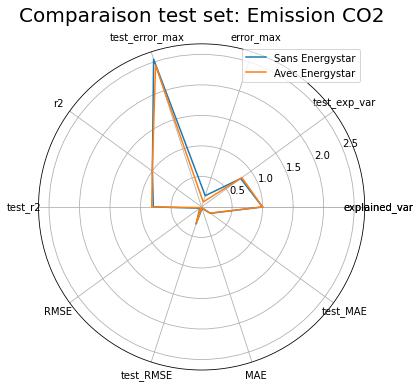

In [204]:

categories=df_res_tot.T.index
categories = [*categories, categories[0]]
dtest=list(df_res_tot.iloc[0].values)
dtrain=list(df_res_tot.iloc[1].values)
dtest = [*dtest, dtest[0]]
dtrain = [*dtrain, dtrain[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
plt.figure(figsize=(6,6))

plt.subplot(polar=True)
plt.plot(label_loc, dtest, label='Sans Energystar')
plt.plot(label_loc, dtrain, label='Avec Energystar')
plt.title('Comparaison test set: Emission CO2', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()



### 3-Modélisation Emission CO2 <a class="anchor" id="chapter3"></a>


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\miche\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log de la consommation énergie')

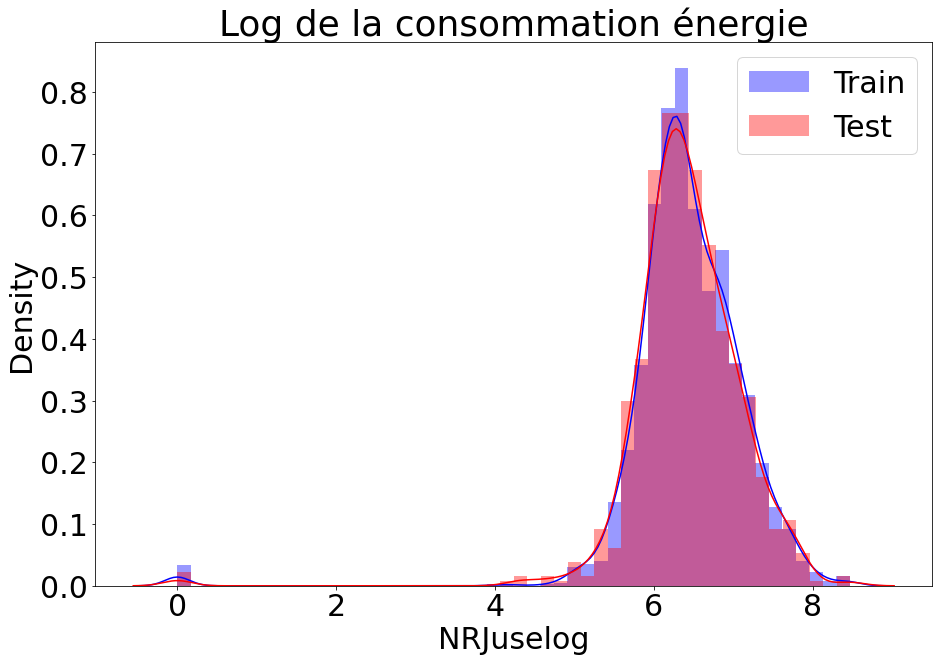

In [27]:

f, axes = plt.subplots(figsize=(15, 10))
               


sns.distplot(Train['NRJuselog'], color="b",ax=axes,label='Train',bins=50);
sns.distplot(Test['NRJuselog'], color="r",ax=axes,label='Test',bins=50);
plt.legend()
plt.title('Log de la consommation énergie')



### Premier cas: Modèle sur les données des bâtiments sans energystar
#### Sélection des données

In [899]:
df_res_use=pd.DataFrame(columns=['explained_var','test_exp_var','error_max','test_error_max','r2','test_r2','RMSE','test_RMSE','MAE','test_MAE'])

In [147]:
X=Train.dropna()[['DataYear','CouncilDistrictCode','NumberofBuildings','LargestPropertyUseType','NumberofFloors','ParkingPourcent','BuildingsPourcent','LargestPourcent','age','GFAtotlog']]
ytr=pd.DataFrame(Train.dropna().NRJuselog).values      

In [148]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
num_attribs = list(X.drop(['DataYear','CouncilDistrictCode','LargestPropertyUseType'],axis=1))
cat_attribs = ['DataYear','CouncilDistrictCode','LargestPropertyUseType']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])


In [149]:
Xtr = full_pipeline.fit_transform(X)

In [10]:
ytst=pd.DataFrame(Test.dropna().NRJuselog).values      
Xtst=full_pipeline.transform(Test.dropna()[['DataYear','CouncilDistrictCode','NumberofBuildings','LargestPropertyUseType','NumberofFloors','ParkingPourcent','BuildingsPourcent','LargestPourcent','age','GFAtotlog']])

#### Choix des modèles:
##### LinearRegression

In [867]:
lin_reg = LinearRegression()
lin_reg.fit(Xtr, ytr)

LinearRegression()

In [868]:
retour_score(Xtr,ytr,Xtst,ytst,lin_reg,name='regression lineaire')

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.691806,0.357277,1.728238,6.233489,0.691806,-67.661765,0.307076,4.828077,0.217842,4.805426


In [900]:
df_res_use=df_res_use.append(retour_score(Xtr,ytr,Xtst,ytst,lin_reg,name='regression lineaire'))

##### ElasticNet pour savoir lasso, Ridge et linearReg

In [871]:
parametersGrid = {"alpha": [0, 0.0001,0.001, 0.01, 0.1, 1, 10, 100],
                  "max_iter": [ 10,8, 7,5],
                      "l1_ratio": np.arange(0.0, 1.1, 0.1),
                 }

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error',refit=True)
grid.fit(Xtr,ytr)
Y_pred = grid.predict(Xtst)
print(grid.best_estimator_)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:593: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.17132594222102, tolerance: 0.03818668313301996

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:593: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.

ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=7)


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.321912744234794, tolerance: 0.047026379037613565



In [872]:
print(grid.best_estimator_)

ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=7)


In [901]:
df_res_use=df_res_use.append(retour_score(Xtr,ytr,Xtst,ytst,grid,name='elasticnet'))

In [902]:
df_res_use

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.691806,0.555593,1.728238,6.233489,0.691806,0.55244,0.307076,0.410709,0.217842,0.230307
elasticnet,0.691186,0.556868,1.730307,6.248932,0.691186,0.55366,0.307385,0.410149,0.218189,0.229445


##### Svr avec RBF en noyau

In [980]:
svr = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-4, 2, 5)},refit=True,
     scoring='neg_mean_squared_error'
)
svr.fit(Xtr,ytr)



C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1.0, 10.0, 100.0, 1000.0],
                         'gamma': array([1.00000000e-04, 3.16227766e-03, 1.00000000e-01, 3.16227766e+00,
       1.00000000e+02])},
             scoring='neg_mean_squared_error')

In [981]:
svr_ss=svr.best_estimator_
svr_ss.fit(Xtr,ytr)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVR(C=100.0, gamma=0.0031622776601683794)

In [982]:
df_res_use=df_res_use.append(retour_score(Xtr,ytr,Xtst,ytst,svr_ss,name=str(svr.best_estimator_)))

In [ ]:
df_res_use

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.691806,0.555593,1.728238,6.233489,0.691806,0.552440,0.307076,0.410709,0.217842,0.230307
elasticnet,0.691186,0.556868,1.730307,6.248932,0.691186,0.553660,0.307385,0.410149,0.218189,0.229445
"SVR(C=100.0, gamma=0.0031622776601683794)",0.724547,0.569493,1.663091,6.245252,0.724521,0.566637,0.290321,0.404142,0.197051,0.217075


##### knnregressor

In [887]:
knnreg = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={"n_neighbors":list(range(2,50))}, refit=True,
     scoring='neg_mean_squared_error'
)
knnreg.fit(Xtr,ytr)
print(knnreg.best_estimator_)


KNeighborsRegressor(n_neighbors=12)


In [905]:
df_res_use=df_res_use.append(retour_score(Xtr,ytr,Xtst,ytst,knnreg,name=str(knnreg.best_estimator_)))

In [906]:
df_res_use

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.691806,0.555593,1.728238,6.233489,0.691806,0.552440,0.307076,0.410709,0.217842,0.230307
elasticnet,0.691186,0.556868,1.730307,6.248932,0.691186,0.553660,0.307385,0.410149,0.218189,0.229445
"SVR(C=100.0, gamma=0.0031622776601683794)",0.724547,0.569493,1.663091,6.245252,0.724521,0.566637,0.290321,0.404142,0.197051,0.217075
KNeighborsRegressor(n_neighbors=12),0.685857,0.530027,1.843841,6.343694,0.683633,0.529964,0.311121,0.420895,0.225755,0.242136


##### Gradientboosting regressor

In [893]:
parameters = {'learning_rate': [0.001,0.01,0.1,0.3,0.5,0.9],
                  'subsample'    : [0.2,0.85,1],
                  'n_estimators' : [100,500,1700,1600,2000,2500],
                  'max_depth'    : [1,4,8,10,14],
              
                 }


GBR=GradientBoostingRegressor()
test_grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, n_jobs=-1)
test_grid_GBR.fit(Xtr, ytr)
print(test_grid_GBR.best_estimator_)


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:925: RuntimeWarning:

overflow encountered in square

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=2000,
                          subsample=0.85)


In [908]:
df_res_use=df_res_use.append(retour_score(Xtr,ytr,Xtst,ytst,test_grid_GBR,name='GradientBoostinginch'))

In [909]:
df_res_use

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.691806,0.555593,1.728238,6.233489,0.691806,0.552440,0.307076,0.410709,0.217842,0.230307
elasticnet,0.691186,0.556868,1.730307,6.248932,0.691186,0.553660,0.307385,0.410149,0.218189,0.229445
"SVR(C=100.0, gamma=0.0031622776601683794)",0.724547,0.569493,1.663091,6.245252,0.724521,0.566637,0.290321,0.404142,0.197051,0.217075
KNeighborsRegressor(n_neighbors=12),0.685857,0.530027,1.843841,6.343694,0.683633,0.529964,0.311121,0.420895,0.225755,0.242136
GradientBoostinginch,0.999167,0.708596,0.065764,6.278809,0.999167,0.705925,0.015960,0.332918,0.012096,0.124498


Text(0.5, 0, 'Nombre estimateur')

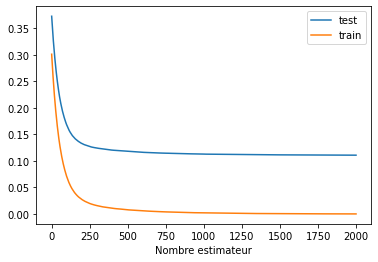

In [910]:
err=[metrics.mean_squared_error(ytst,ypred) for ypred in test_grid_GBR.best_estimator_.staged_predict(Xtst)]
errt=[metrics.mean_squared_error(ytr,ypred) for ypred in test_grid_GBR.best_estimator_.staged_predict(Xtr)]
brdt_n_rdt=np.argmin(err)
err[brdt_n_rdt]
plt.plot(err,label='test')
plt.plot(errt,label='train')
plt.legend()
plt.xlabel('Nombre estimateur')

In [11]:
xgbnrj=GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=2000,
                          subsample=0.85)

In [12]:
xgbnrj.fit(Xtr,ytr)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=2000,
                          subsample=0.85)

In [150]:
df_featureimp=pd.DataFrame(xgbnrj.feature_importances_.reshape(1,-1),columns=full_pipeline.transformers_[0][-1]+list(full_pipeline.named_transformers_['cat'].get_feature_names()))

In [152]:
df_featureimp.sum(axis=1)

0    1.0
dtype: float64

Text(0.5, 1.0, 'Importance des variables en % sans EnergyStarScore')

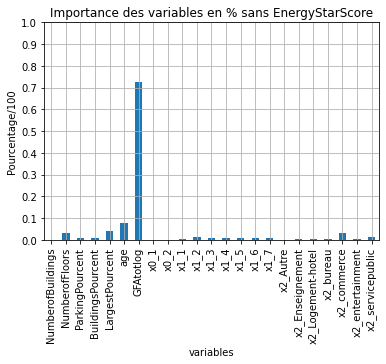

In [151]:
df_featureimp.T.plot(kind='bar',legend=False)
plt.grid()
plt.yticks(np.arange(0,1.1,0.1))
plt.ylabel('Pourcentage/100')
plt.xlabel('variables')

plt.title('Importance des variables en % sans EnergyStarScore')

In [15]:
retour_score(Xtr,ytr,Xtst,ytst,xgbnrj,name='GradientBoostinginch')

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
GradientBoostinginch,0.998989,0.735809,0.083453,6.250641,0.998989,0.735401,0.017214,0.332192,0.012957,0.124398


##### RandomForestRegressor

In [911]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_rf_ss = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 2,refit=True)

In [912]:
grid_rf_ss.fit(Xtr,ytr)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [913]:
df_res_use=df_res_use.append(retour_score(Xtr,ytr,Xtst,ytst,grid_rf_ss,name=str(grid_rf_ss.best_estimator_)))


                                                    explained_var  \
regression lineaire                                      0.691806   
elasticnet                                               0.691186   
SVR(C=100.0, gamma=0.0031622776601683794)                0.724547   
KNeighborsRegressor(n_neighbors=12)                      0.685857   
GradientBoostinginch                                     0.999167   
RandomForestRegressor(max_depth=110, max_featur...       0.775411   

                                                    test_exp_var  error_max  \
regression lineaire                                     0.555593   1.728238   
elasticnet                                              0.556868   1.730307   
SVR(C=100.0, gamma=0.0031622776601683794)               0.569493   1.663091   
KNeighborsRegressor(n_neighbors=12)                     0.530027   1.843841   
GradientBoostinginch                                    0.708596   0.065764   
RandomForestRegressor(max_depth=110, max_f

In [914]:
df_res_use

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.691806,0.555593,1.728238,6.233489,0.691806,0.552440,0.307076,0.410709,0.217842,0.230307
elasticnet,0.691186,0.556868,1.730307,6.248932,0.691186,0.553660,0.307385,0.410149,0.218189,0.229445
"SVR(C=100.0, gamma=0.0031622776601683794)",0.724547,0.569493,1.663091,6.245252,0.724521,0.566637,0.290321,0.404142,0.197051,0.217075
KNeighborsRegressor(n_neighbors=12),0.685857,0.530027,1.843841,6.343694,0.683633,0.529964,0.311121,0.420895,0.225755,0.242136
GradientBoostinginch,0.999167,0.708596,0.065764,6.278809,0.999167,0.705925,0.015960,0.332918,0.012096,0.124498
"RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=3,\n min_samples_split=8)",0.775411,0.552832,1.333055,6.325635,0.775411,0.551438,0.262137,0.411168,0.188523,0.230915


##### MLPregressor

In [915]:
distributions = {'hidden_layer_sizes':[(100),(100,100),(100,100,100)]}
MLPreg = MLPRegressor(activation = 'relu', learning_rate='invscaling',verbose=True,early_stopping=True)
grid_MLP_ss = GridSearchCV(estimator = MLPreg, param_grid = distributions, n_jobs = -1, verbose = 2,refit=True)
grid_MLP_ss.fit(Xtr,ytr)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iteration 1, loss = 18.89293781
Validation score: -79.366636
Iteration 2, loss = 11.17986804
Validation score: -35.173317
Iteration 3, loss = 3.61398042
Validation score: -8.192740
Iteration 4, loss = 1.69900103
Validation score: -12.486937
Iteration 5, loss = 1.19680020
Validation score: -4.525110
Iteration 6, loss = 0.66168185
Validation score: -4.261584
Iteration 7, loss = 0.52598423
Validation score: -2.595045
Iteration 8, loss = 0.35350499
Validation score: -2.568231
Iteration 9, loss = 0.30477247
Validation score: -1.658043
Iteration 10, loss = 0.23939005
Validation score: -1.367093
Iteration 11, loss = 0.20875541
Validation score: -1.163695
Iteration 12, loss = 0.18599399
Validation score: -0.973634
Iteration 13, loss = 0.16905589
Validation score: -0.763840
Iteration 14, loss = 0.15695023
Validation score: -0.625410
Iteration 15, loss = 0.14537806
Validation score: -0.513188
Iteration 16, loss = 0.13550859
Validation score: -0.406528
Iteration 17, loss = 0.12644586
Validation s

GridSearchCV(estimator=MLPRegressor(early_stopping=True,
                                    learning_rate='invscaling', verbose=True),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [100, (100, 100),
                                                (100, 100, 100)]},
             verbose=2)

In [916]:
grid_MLP_ss.best_estimator_

MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 100, 100),
             learning_rate='invscaling', verbose=True)

In [923]:
distributions = {'hidden_layer_sizes':[(1000),(1000,1000),]}
MLPreg = MLPRegressor(activation = 'relu', learning_rate='invscaling',verbose=True,early_stopping=True)
grid_MLP_ss = GridSearchCV(estimator = MLPreg, param_grid = distributions, n_jobs = -1, verbose = 2,refit=True)
grid_MLP_ss.fit(Xtr,ytr)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iteration 1, loss = 18.41827378
Validation score: -96.199828
Iteration 2, loss = 12.15102349
Validation score: -58.939096
Iteration 3, loss = 7.07074256
Validation score: -29.581182
Iteration 4, loss = 3.21535914
Validation score: -9.996340
Iteration 5, loss = 0.96142447
Validation score: -2.260828
Iteration 6, loss = 0.40525689
Validation score: -2.642745
Iteration 7, loss = 0.51502431
Validation score: -2.521047
Iteration 8, loss = 0.38928114
Validation score: -1.080467
Iteration 9, loss = 0.22758464
Validation score: -0.458729
Iteration 10, loss = 0.18977019
Validation score: -0.332635
Iteration 11, loss = 0.17994407
Validation score: -0.134662
Iteration 12, loss = 0.15461327
Validation score: 0.057075
Iteration 13, loss = 0.13599745
Validation score: 0.143975
Iteration 14, loss = 0.12727532
Validation score: 0.211898
Iteration 15, loss = 0.11786265
Validation score: 0.265340
Iteration 16, loss = 0.10989029
Validation score: 0.303012
Iteration 17, loss = 0.10371725
Validation score:

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



GridSearchCV(estimator=MLPRegressor(early_stopping=True,
                                    learning_rate='invscaling', verbose=True),
             n_jobs=-1, param_grid={'hidden_layer_sizes': [1000, (1000, 1000)]},
             verbose=2)

In [924]:
retour_score(Xtr,ytr,Xtst,ytst,grid_MLP_ss,name=str(grid_MLP_ss.best_estimator_))

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"MLPRegressor(early_stopping=True, hidden_layer_sizes=1000,\n learning_rate='invscaling', verbose=True)",0.785833,0.580849,1.505932,6.300015,0.785724,0.580677,0.256047,0.397542,0.175808,0.215433


In [927]:
df_res_use=df_res_use.append(retour_score(Xtr,ytr,Xtst,ytst,grid_MLP_ss,name=str(grid_MLP_ss.best_estimator_)))

In [928]:
df_res_use

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.691806,0.555593,1.728238,6.233489,0.691806,0.552440,0.307076,0.410709,0.217842,0.230307
elasticnet,0.691186,0.556868,1.730307,6.248932,0.691186,0.553660,0.307385,0.410149,0.218189,0.229445
"SVR(C=100.0, gamma=0.0031622776601683794)",0.724547,0.569493,1.663091,6.245252,0.724521,0.566637,0.290321,0.404142,0.197051,0.217075
KNeighborsRegressor(n_neighbors=12),0.685857,0.530027,1.843841,6.343694,0.683633,0.529964,0.311121,0.420895,0.225755,0.242136
GradientBoostinginch,0.999167,0.708596,0.065764,6.278809,0.999167,0.705925,0.015960,0.332918,0.012096,0.124498
"RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=3,\n min_samples_split=8)",0.775411,0.552832,1.333055,6.325635,0.775411,0.551438,0.262137,0.411168,0.188523,0.230915
"MLPRegressor(early_stopping=True, hidden_layer_sizes=1000,\n learning_rate='invscaling', verbose=True)",0.785833,0.580849,1.505932,6.300015,0.785724,0.580677,0.256047,0.397542,0.175808,0.215433


#### Affichage du résultat et comparaison: 

In [930]:
df_ss_conso=df_res_use.copy()

In [932]:
df_ss_conso.columns

Index(['explained_var', 'test_exp_var', 'error_max', 'test_error_max', 'r2',
       'test_r2', 'RMSE', 'test_RMSE', 'MAE', 'test_MAE'],
      dtype='object')

In [933]:
df_ss_conso[['explained_var','test_exp_var','r2','test_r2']]=1/df_ss_conso[['explained_var','test_exp_var','r2','test_r2']]

In [934]:
scaler=MinMaxScaler(feature_range=(0.1,0.7))
df_ss_conso[['explained_var','error_max','r2','RMSE','MAE']]=scaler.fit_transform(df_ss_conso[['explained_var','error_max','r2','RMSE','MAE']])

In [935]:
df_ss_conso[['test_exp_var','test_error_max','test_r2','test_RMSE','test_MAE']]=scaler.transform(df_ss_conso[['test_exp_var','test_error_max','test_r2','test_RMSE','test_MAE']])

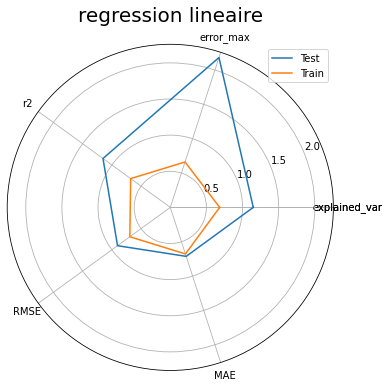

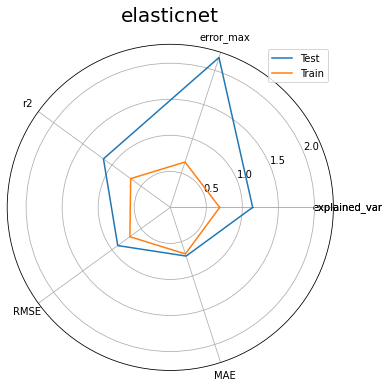

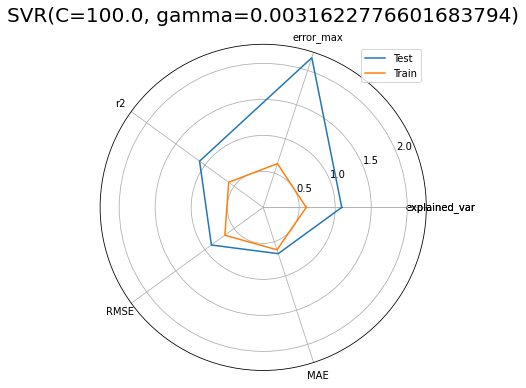

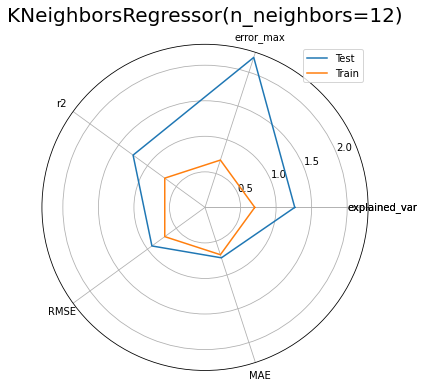

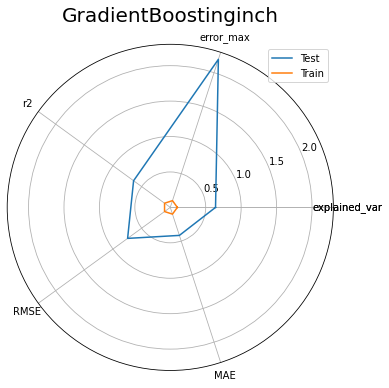

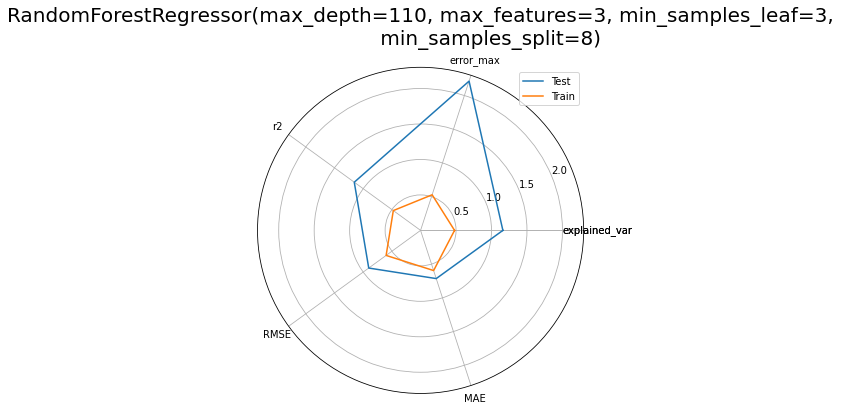

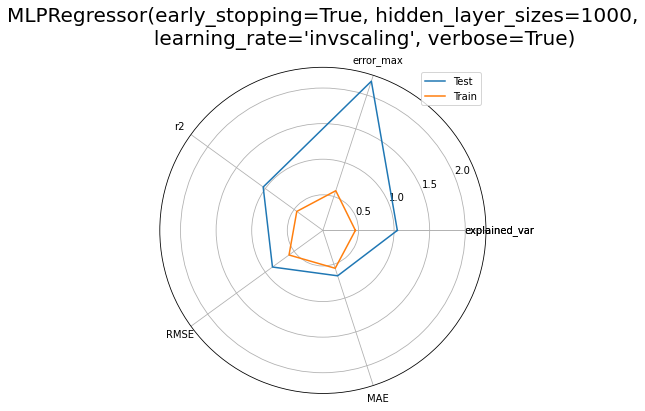

In [937]:

for col in df_ss_conso.index:
    spider_plot(df_ss_conso.loc[col],name=col,show=False)
 

###  Modèle sur les données des bâtiments pour la consommation avec Energystar
#### Sélection des données

In [938]:
df_res_usenrj=pd.DataFrame(columns=['explained_var','test_exp_var','error_max','test_error_max','r2','test_r2','RMSE','test_RMSE','MAE','test_MAE'])

In [28]:
X=Train.dropna()[['ENERGYSTARScore','DataYear','CouncilDistrictCode','NumberofBuildings','LargestPropertyUseType','NumberofFloors','ParkingPourcent','BuildingsPourcent','LargestPourcent','age','GFAtotlog']]
ytr=pd.DataFrame(Train.dropna().NRJuselog).values  

In [29]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
num_attribs = list(X.drop(['DataYear','CouncilDistrictCode','LargestPropertyUseType'],axis=1))
cat_attribs = ['DataYear','CouncilDistrictCode','LargestPropertyUseType']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])



In [30]:
Xtr=full_pipeline.fit_transform(X)

In [38]:
ytst_nrj=pd.DataFrame(Test.dropna().NRJuselog).values      
Xtst_nrj=full_pipeline.transform(Test.dropna()[['ENERGYSTARScore','DataYear','CouncilDistrictCode','NumberofBuildings','LargestPropertyUseType','NumberofFloors','ParkingPourcent','BuildingsPourcent','LargestPourcent','age','GFAtotlog']])

In [31]:
Xtr.shape

(1546, 24)

#### différents modèles: 
##### Elasticnet

In [949]:
parametersGrid = {"alpha": [0, 0.0001,0.001, 0.01, 0.1, 1, 10, 100],
                  "max_iter": [ 9,8, 7],
                      "l1_ratio": np.arange(0.0, 1.1, 0.1),
                 }

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error',refit=True)
grid.fit(Xtr,ytr)


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:593: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.550106285242336, tolerance: 0.03818668313301996

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:593: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent

GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_iter': [9, 8, 7]},
             scoring='neg_mean_squared_error')

In [950]:
grid.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=9)

In [952]:
df_res_usenrj=df_res_usenrj.append(retour_score(Xtr,ytr,Xtst_nrj,ytst_nrj,grid,name=str(grid.best_estimator_)))

In [953]:
df_res_usenrj

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=9)",0.774575,0.641126,1.535964,6.128533,0.774575,0.636459,0.262625,0.370156,0.179222,0.188061


###### SVR


In [954]:
svr = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-4, 2, 5)},refit=True,
     scoring='neg_mean_squared_error'
)
svr.fit(Xtr,ytr)
print(svr.best_estimator_)


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\miche\anaconda3\envs\tf\lib

SVR(C=100.0, gamma=0.0031622776601683794)


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [955]:
df_res_usenrj=df_res_usenrj.append(retour_score(Xtr,ytr,Xtst_nrj,ytst_nrj,svr,name=str(svr.best_estimator_)))

In [956]:
df_res_usenrj

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=9)",0.774575,0.641126,1.535964,6.128533,0.774575,0.636459,0.262625,0.370156,0.179222,0.188061
"SVR(C=100.0, gamma=0.0031622776601683794)",0.805517,0.663289,1.485437,6.124608,0.805493,0.660243,0.243950,0.357843,0.159042,0.169430


##### KNNreg

In [957]:
knnreg = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={"n_neighbors":list(range(2,50))}, refit=True,
     scoring='neg_mean_squared_error'
)
knnreg.fit(Xtr,ytr)
print(knnreg.best_estimator_)

KNeighborsRegressor(n_neighbors=8)


In [958]:
df_res_usenrj=df_res_usenrj.append(retour_score(Xtr,ytr,Xtst_nrj,ytst_nrj,knnreg,name=str(knnreg.best_estimator_)))

In [959]:
df_res_usenrj

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=9)",0.774575,0.641126,1.535964,6.128533,0.774575,0.636459,0.262625,0.370156,0.179222,0.188061
"SVR(C=100.0, gamma=0.0031622776601683794)",0.805517,0.663289,1.485437,6.124608,0.805493,0.660243,0.243950,0.357843,0.159042,0.169430
KNeighborsRegressor(n_neighbors=8),0.754370,0.586299,1.696108,6.279763,0.751920,0.586246,0.275505,0.394893,0.196933,0.217823


##### GradientBoostingRegressor

In [960]:
parameters = {'learning_rate': [0.001,0.01,0.1,],
                  'subsample'    : [0.85,0.95],
                  'n_estimators' : [1400,1700,1600,2000,2500],
                  'max_depth'    : [4,8,10],
              
                 }


GBR=GradientBoostingRegressor()
test_grid_GBR_nrj = GridSearchCV(estimator=GBR, param_grid = parameters, n_jobs=-1)
test_grid_GBR_nrj.fit(Xtr, ytr)
print(test_grid_GBR_nrj.best_estimator_)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingRegressor(max_depth=4, n_estimators=1700, subsample=0.85)


In [961]:
best_nrj=test_grid_GBR_nrj.best_estimator_
best_nrj.fit(Xtr, ytr)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingRegressor(max_depth=4, n_estimators=1700, subsample=0.85)

In [39]:
xgbnrjstar=GradientBoostingRegressor(max_depth=4, n_estimators=1700, subsample=0.85)
xgbnrjstar.fit(Xtr,ytr)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(max_depth=4, n_estimators=1700, subsample=0.85)

In [107]:
df_featureimp=pd.DataFrame(xgbnrjstar.feature_importances_.reshape(1,-1),columns=full_pipeline.transformers_[0][-1]+list(full_pipeline.named_transformers_['cat'].get_feature_names()))

Text(0.5, 1.0, 'Importance des variables en % avec EnergyStarScore')

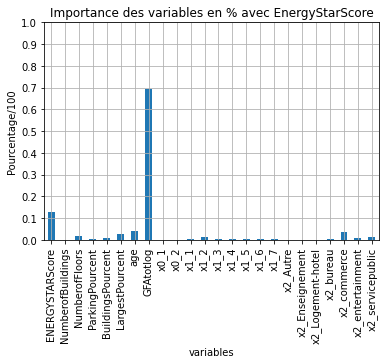

In [121]:
df_featureimp.T.plot(kind='bar',legend=False)
plt.grid()
plt.yticks(np.arange(0,1.1,0.1))
plt.ylabel('Pourcentage/100')
plt.xlabel('variables')

plt.title('Importance des variables en % avec EnergyStarScore')

In [40]:
Xtst_nrj.shape

(512, 24)

In [41]:
retour_score(Xtr,ytr,Xtst_nrj,ytst_nrj,xgbnrjstar)

,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
GradientBoostingRegressor'>,0.999812,0.78634,0.034657,5.663729,0.999812,0.786312,0.007413,0.298528,0.005835,0.106502


In [963]:
df_res_usenrj=df_res_usenrj.append(retour_score(Xtr,ytr,Xtst_nrj,ytst_nrj,best_nrj,name=str(test_grid_GBR_nrj.best_estimator_)))

##### RandomForestRegressor

In [965]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestRegressor()
gridrfr = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 2,refit=True)

In [966]:
gridrfr.fit(Xtr,ytr)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [967]:
df_res_usenrj=df_res_usenrj.append(retour_score(Xtr,ytr,Xtst_nrj,ytst_nrj,gridrfr,name=str(gridrfr.best_estimator_)))

##### MLPRegressor

In [968]:
distributions = {'hidden_layer_sizes':[(100),(1000,1000),(1000)]}
MLPreg = MLPRegressor(activation = 'relu', learning_rate='invscaling',verbose=True,early_stopping=True)
grid_MLP = GridSearchCV(estimator = MLPreg, param_grid = distributions, n_jobs = -1, verbose = 2,refit=True)
grid_MLP.fit(Xtr,ytr)
df_res_usenrj=df_res_usenrj.append(retour_score(Xtr,ytr,Xtst_nrj,ytst_nrj,grid_MLP,name=str(grid_MLP.best_estimator_)))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\miche\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iteration 1, loss = 7.76073194
Validation score: -25.176672
Iteration 2, loss = 3.14170315
Validation score: -5.495064
Iteration 3, loss = 1.34651711
Validation score: -3.547037
Iteration 4, loss = 0.48492964
Validation score: -3.385557
Iteration 5, loss = 0.43294927
Validation score: -1.197493
Iteration 6, loss = 0.29763316
Validation score: -0.684449
Iteration 7, loss = 0.19771054
Validation score: -0.637302
Iteration 8, loss = 0.15979135
Validation score: -0.310198
Iteration 9, loss = 0.13625564
Validation score: -0.044503
Iteration 10, loss = 0.11438153
Validation score: 0.073717
Iteration 11, loss = 0.09815220
Validation score: 0.166974
Iteration 12, loss = 0.08666713
Validation score: 0.232428
Iteration 13, loss = 0.07677396
Validation score: 0.320488
Iteration 14, loss = 0.06926702
Validation score: 0.370148
Iteration 15, loss = 0.06205992
Validation score: 0.426824
Iteration 16, loss = 0.05698690
Validation score: 0.461214
Iteration 17, loss = 0.05169417
Validation score: 0.498

### Analyse des erreurs et comparaison entre les deux meilleurs modèles avec et sans nrjstar

In [42]:
ypred_=xgbnrj.predict(Xtst)
ypred_nrj=xgbnrjstar.predict(Xtst_nrj)

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


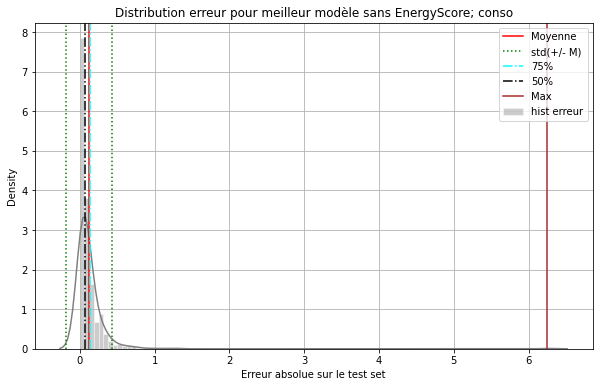

In [45]:
err=pd.DataFrame(np.abs(ypred_.reshape(-1,1)-ytst))
plt.figure(figsize=(10,6))
sns.distplot(err,bins=100,label='hist erreur',hist_kws={'edgecolor':"white",'color':'gray'},kde_kws={'color':'gray'})
plt.axvline(err.mean().values,color='red',label='Moyenne',linestyle='-')
plt.axvline(err.mean().values-err.describe().loc['std'].values,color='green',label='std(+/- M)',linestyle=':')
plt.axvline(err.mean().values+err.describe().loc['std'].values,color='green',linestyle=':')
plt.axvline(err.describe().loc['75%'].values,color='cyan',label='75%',linestyle='-.')
plt.axvline(err.describe().loc['50%'].values,color='black',label='50%',linestyle='-.')
plt.axvline(err.max().values,color='brown',label='Max',linestyle='-')
plt.xlabel('Erreur absolue sur le test set')
plt.title('Distribution erreur pour meilleur modèle sans EnergyScore; conso')
plt.legend(loc='upper right')
plt.grid()

C:\Users\miche\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


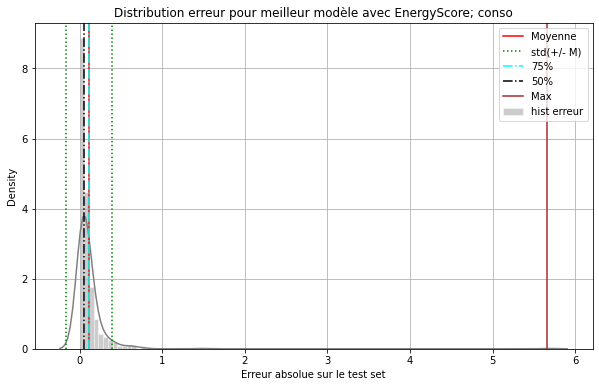

In [46]:
err=pd.DataFrame(np.abs(ypred_nrj.reshape(-1,1)-ytst_nrj))
plt.figure(figsize=(10,6))
sns.distplot(err,bins=100,label='hist erreur',hist_kws={'edgecolor':"white",'color':'gray'},kde_kws={'color':'gray'})
plt.axvline(err.mean().values,color='red',label='Moyenne',linestyle='-')
plt.axvline(err.mean().values-err.describe().loc['std'].values,color='green',label='std(+/- M)',linestyle=':')
plt.axvline(err.mean().values+err.describe().loc['std'].values,color='green',linestyle=':')
plt.axvline(err.describe().loc['75%'].values,color='cyan',label='75%',linestyle='-.')
plt.axvline(err.describe().loc['50%'].values,color='black',label='50%',linestyle='-.')
plt.axvline(err.max().values,color='brown',label='Max',linestyle='-')
plt.xlabel('Erreur absolue sur le test set')
plt.title('Distribution erreur pour meilleur modèle avec EnergyScore; conso')
plt.legend(loc='upper right')
plt.grid()

In [974]:
ypred_=best.predict(Xtst)
ypred_nrj=best_nrj.predict(Xtst_nrj)

In [973]:
df_res_use.style.background_gradient(cmap=cm).set_precision(4).highlight_null('red').highlight_min(axis=0, color='red').highlight_max(axis=0, color='blue')


<ipython-input-973-3c66786e56f8>:1: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
regression lineaire,0.6918,0.5556,1.7282,6.2335,0.6918,0.5524,0.3071,0.4107,0.2178,0.2303
elasticnet,0.6912,0.5569,1.7303,6.2489,0.6912,0.5537,0.3074,0.4101,0.2182,0.2294
"SVR(C=100.0, gamma=0.0031622776601683794)",0.7245,0.5695,1.6631,6.2453,0.7245,0.5666,0.2903,0.4041,0.1971,0.2171
KNeighborsRegressor(n_neighbors=12),0.6859,0.5300,1.8438,6.3437,0.6836,0.5300,0.3111,0.4209,0.2258,0.2421
GradientBoostinginch,0.9992,0.7086,0.0658,6.2788,0.9992,0.7059,0.0160,0.3329,0.0121,0.1245
"RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8)",0.7754,0.5528,1.3331,6.3256,0.7754,0.5514,0.2621,0.4112,0.1885,0.2309
"MLPRegressor(early_stopping=True, hidden_layer_sizes=1000, learning_rate='invscaling', verbose=True)",0.7858,0.5808,1.5059,6.3000,0.7857,0.5807,0.2560,0.3975,0.1758,0.2154


In [972]:
cm = sns.light_palette("green", as_cmap=True) 

df_res_usenrj.style.background_gradient(cmap=cm).set_precision(4).highlight_null('red').highlight_min(axis=0, color='red').highlight_max(axis=0, color='blue')


<ipython-input-972-6ef546870926>:3: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,explained_var,test_exp_var,error_max,test_error_max,r2,test_r2,RMSE,test_RMSE,MAE,test_MAE
"ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=9)",0.7746,0.6411,1.5360,6.1285,0.7746,0.6365,0.2626,0.3702,0.1792,0.1881
"SVR(C=100.0, gamma=0.0031622776601683794)",0.8055,0.6633,1.4854,6.1246,0.8055,0.6602,0.2440,0.3578,0.1590,0.1694
KNeighborsRegressor(n_neighbors=8),0.7544,0.5863,1.6961,6.2798,0.7519,0.5862,0.2755,0.3949,0.1969,0.2178
"GradientBoostingRegressor(max_depth=4, n_estimators=1700, subsample=0.85)",0.9998,0.7614,0.0308,5.7607,0.9998,0.7587,0.0082,0.3016,0.0064,0.1096
"RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8)",0.8216,0.6187,1.3177,6.0505,0.8216,0.6167,0.2336,0.3801,0.1671,0.2083
"MLPRegressor(early_stopping=True, hidden_layer_sizes=(1000, 1000), learning_rate='invscaling', verbose=True)",0.8580,0.6484,1.1923,6.0620,0.8577,0.6477,0.2086,0.3644,0.1404,0.1799
